# Import liberaries

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import pandas_datareader as pdr
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from keras.optimizers import SGD
from keras.optimizers import Adam
import time
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.svm import SVR, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost 
from xgboost import XGBClassifier
from xgboost import XGBRegressor

Using TensorFlow backend.


# Input Data from Yahoo Finance

In [2]:
DF = pdr.get_data_yahoo('spy', start = '2000-01-01', end = '2017-10-1')
DF.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,148.25000,143.875000,148.25000,145.4375,8164300.0,100.470520
2000-01-04,144.06250,139.640625,143.53125,139.7500,8089800.0,96.541473
2000-01-05,141.53125,137.250000,139.93750,140.0000,12177900.0,96.714218
2000-01-06,141.50000,137.750000,139.62500,137.7500,6227200.0,95.159882
2000-01-07,145.75000,140.062500,140.31250,145.7500,8066500.0,100.686371


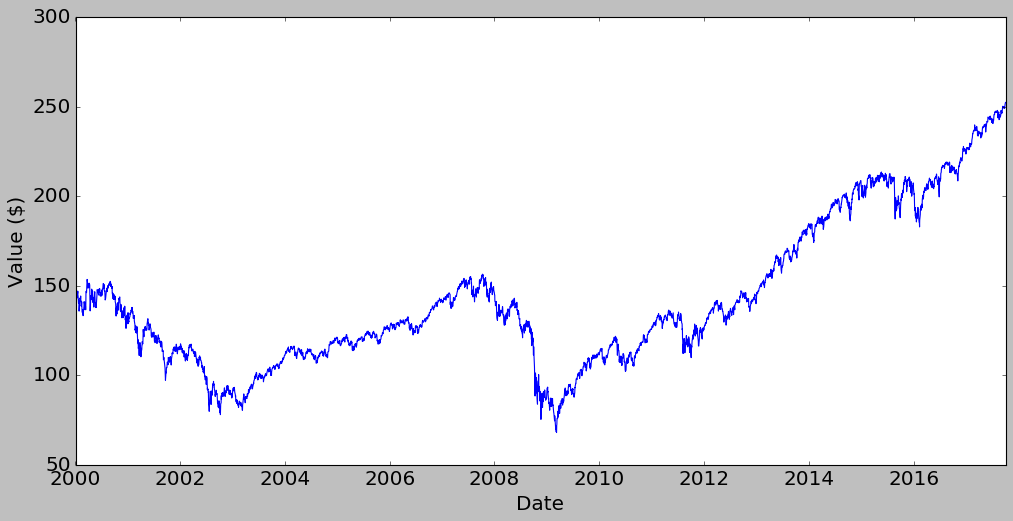

In [63]:
plt.figure(figsize=(15,7))
plt.plot(DF.Close)
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.rcParams.update({'font.size': 18})

# Define Functions

In [3]:
#creating datasets from the dataframe, make data stationary:
def difference_pct_back(datafile, lag = 1):
    diff = [0] * lag
    for i in range(lag,len(datafile)):
        diff.append(datafile[i]/datafile[i-lag]-1)
    return diff

def create_dataset_percentage_gap(dataset, window_size, look_forward, gap): #MinMaxScaler(feature_range=(0, 1)) 
    i = 0
    data_X, data_Y = [], []
    while i in range(len(dataset) - window_size - look_forward):
        a = dataset[i:(i + window_size), :]
        data_X.append(a)
        b = dataset[i + window_size + look_forward-1, 0]/dataset[i+window_size-1,0]-1
        data_Y.append(b)
        i += gap
        
    x = np.array(data_X)
    y = np.array(data_Y)
    y = y.reshape(-1,1)
    return (x,y)

def create_dataset_difference_gap(dataset, window_size, look_forward, gap): #MinMaxScaler(feature_range=(0, 1)) 
    i = 0
    data_X, data_Y = [], []
    while i in range(len(dataset) - window_size - look_forward):
        a = dataset[i:(i + window_size), :]
        data_X.append(a)
        b = dataset[i + window_size + look_forward-1, 0]-dataset[i+window_size-1,0]
        data_Y.append(b)
        i += gap
        
    x = np.array(data_X)
    y = np.array(data_Y)
    y = y.reshape(-1,1)
    return (x,y)

#regression to classification:
def y_classifier(array, threshold):
    classes = []
    for i in range(len(array)):
        if array[i,0] > threshold:
            classes.append(1)
        elif array[i,0] < -1*threshold:
            classes.append(-1)
        else:
            classes.append(0)
    return np.asarray(classes)

#defining moving averages:
def EMA(df, EMA_days):
    sma = np.mean(df[0:EMA_days])
    EMA_list = [0] * (EMA_days - 1)
    EMA_list.append(sma)
    c = 2/(1+EMA_days)
    for i in range(EMA_days,len(df)):
        a = EMA_list[i-1]*(1-c)+ c*df[i]
        EMA_list.append(a)
    return(EMA_list)

def SMA(df, sma_days):
    sma_list = [0] * (sma_days - 1)
    for i in range(sma_days, len(df)+1):
        sma_list.append(np.mean(df[i-sma_days:i]))
    return(sma_list)

#defining some metrics
def rms(y, pred):
    temp = 0
    if len(y) != len(pred):
        return False
    else:
        for i in range(len(y)):
            temp += (y[i][0] - pred[i][0])**2
        return temp/len(y) 

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)+0.0000000001))

def mae(A, F):
    return 1/len(A) * np.sum(np.abs(F - A))

#autocorrelation benchmark:
def benchmark(y, look_forward):
    Y_hat = []
    Y_real = []
    for i in range(2*look_forward, len(y)):
        a = np.mean(y[i-2*look_forward:i-look_forward,0])
        Y_hat.append(a)
        Y_real.append(y[i,0])
    return (np.asarray(Y_real), np.asarray(Y_hat))


def pretty_print_conf_matrix(y_true, y_pred, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)
        
def plot(y_train, prediction_train,y_test, prediction_test):
    fig = plt.figure()
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, prediction_train)
    plt.ylabel('predicted')
    plt.xlabel('actual')
    plt.title('ML-Train')


    plt.subplot(1, 2, 2)
    plt.scatter(y_test, prediction_test)
    plt.ylabel('predicted')
    plt.xlabel('actual')
    plt.title('ML-Test')
    plt.show()

    plt.figure(figsize=(15,8))
    plt.subplot(2, 1, 1)
    plt.plot(prediction_train, marker = '*',linestyle="None", label = 'Pred')
    plt.plot(y_train, marker = '.', label = 'Y', linestyle="None")
    plt.grid()
    plt.legend()
    plt.title('Train')
    plt.subplots_adjust(hspace = 0.4)

    plt.subplot(2, 1, 2)
    plt.plot(prediction_test, marker = '*', label = 'Pred',linestyle="None")
    plt.plot(y_test, marker = '.',linestyle="None" , label = 'Y')
    plt.grid()
    plt.legend()
    plt.title('Test')

#this function changes 1D y array to an array with 3 features that is used for softmax
def y_softmax(array):
    lst = []
    for i in range(len(array)):
        if array[i] == 1:
            lst.append([1,0,0])
        elif array[i] == 0:
            lst.append([0,1,0])
        else:
            lst.append([0,0,1])
    return np.asarray(lst)

        
def softmaxifier(array):
    zeros = [0, 0, 0]
    pred = []
    for i in range(len(array)):
        j = np.argmax(array[i])
        temp = [0,0,0]
        temp[j] = 1
        pred.append(temp)
    return pred

#this function changes 3D y array with 3 features that was generated by softmax to an 1D array for confusion matrix
def desoftmaxer(array):
    lst = []
    for i in range(len(array)):
        if np.argmax(array[i]) == 0:
            lst.append(1)
        elif np.argmax(array[i]) == 1:
            lst.append(0)
        else:
            lst.append(-1)
    return (np.asarray(lst))
#fix random effect
def fix_rnd_Keras():
    seed_value= 0
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    import random
    random.seed(seed_value)
    import numpy as np
    np.random.seed(seed_value)
    import tensorflow as tf
    tf.set_random_seed(seed_value)
    from keras import backend as K
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

#split x and y to test and train that are devisible to batch_size
def test_train_split(x, y, batch_size, train_ratio):       
    train_length = int(len(x)*train_ratio)
    for i in range(train_length, train_length+batch_size):
        remainder = i%batch_size
        if remainder == 0:
            train_length = i
            break
    x_train = x[:train_length,:]
    y_train = y[:train_length]

    for i in range(len(x)-batch_size, len(x)):
        remainder = i%batch_size
        if remainder == 0:
            train_length_test = i
            break
    x_test = x[train_length:train_length_test,:]
    y_test = y[train_length:train_length_test]
    return x_train, y_train, x_test, y_test

# Creating Features

In [4]:
df = DF.Close
df = df.dropna(axis=0, how='any')

#making moving averages
v_10 = SMA(DF.Volume, 10)
v_20 = SMA(DF.Volume, 20)
open_close = (DF.Close/DF.Open - 1).tolist()
high_low = (DF.High/DF.Low - 1).tolist()
EMA_8 = EMA(df,8)
SMA_10 = SMA(df,10)
SMA_20 = SMA(df,20)
SMA_50 = SMA(df,50)
SMA_100 = SMA(df,100)
pct_day = difference_pct_back(df, 1)
list_df = df.tolist()
vol_list = DF.Volume.tolist()
MAs = pd.DataFrame(list(zip(list_df, pct_day, vol_list, v_10, v_20,open_close,high_low, EMA_8, SMA_10, 
                            SMA_20, SMA_50, SMA_100)),columns=['spot', 'pct_day', 'vol', 'v_10', 'v_20',
                            'open_close', 'high_low', 'EMA_8', 'SMA_10', 'SMA_20', 'SMA_50','SMA_100'])

#removing all rows with 0 in them
MAs = MAs[100:]
MAs = MAs.reset_index(drop=True)

#making differences as features
MAs['v10'] = MAs.vol/MAs.v_10 - 1
MAs['v20'] = MAs.vol/MAs.v_20 - 1
MAs['spot_EMA'] = MAs.spot/MAs.EMA_8 - 1
MAs['spot_20SMA'] = MAs.spot/MAs.SMA_20 - 1
MAs['spot_50SMA'] = MAs.spot/MAs.SMA_50 - 1
MAs['spot_100SMA'] = MAs.spot/MAs.SMA_100 - 1
MAs['10_100_SMA'] = MAs.SMA_10/MAs.SMA_100 - 1
MAs['20_50_SMA'] = MAs.SMA_20/MAs.SMA_50 - 1
MAs = MAs.drop(['EMA_8', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'v_10', 'v_20'], 1)

# Initial Visualization

,spot,pct_day,vol,open_close,high_low,v10,v20,spot_EMA,spot_20SMA,spot_50SMA,spot_100SMA,10_100_SMA,20_50_SMA
0,137.84375,-0.017157,8278900.0,-0.020213,0.029725,0.126006,0.078444,-0.018766,-0.031364,-0.053232,-0.035971,-0.006489,-0.022577
1,138.00000,0.001134,4814000.0,-0.005853,0.017181,-0.334878,-0.356438,-0.013785,-0.027843,-0.051072,-0.034760,-0.009733,-0.023894
2,142.50000,0.032609,5362700.0,0.017857,0.024871,-0.268381,-0.273540,0.014233,0.005474,-0.019530,-0.003459,-0.011851,-0.024868
3,142.81250,0.002193,6056500.0,0.001754,0.013415,-0.148930,-0.160474,0.012753,0.008146,-0.016923,-0.001628,-0.014910,-0.024866
4,145.31250,0.017505,8961600.0,0.011309,0.017045,0.207473,0.274632,0.023549,0.024144,0.000820,0.015881,-0.014771,-0.022775


<Figure size 640x480 with 0 Axes>

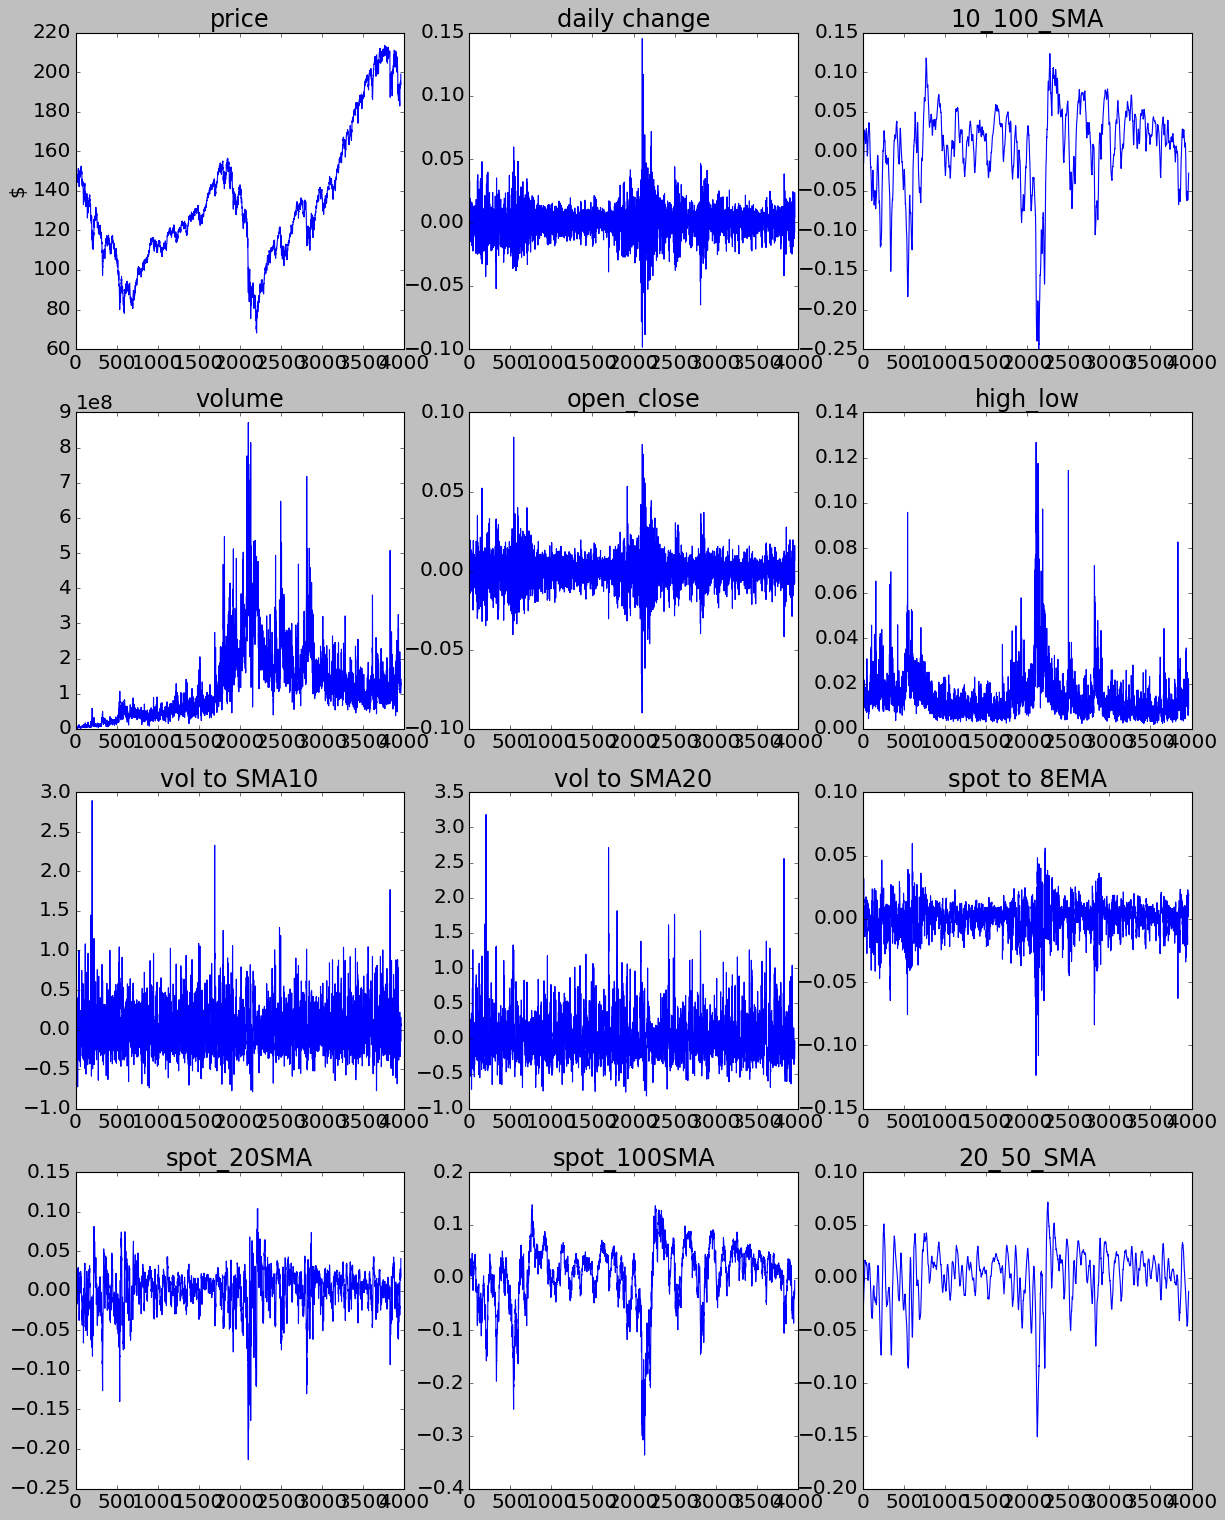

In [57]:
fig = plt.figure()
plt.figure(figsize=(18,14))
           
plt.subplot(4, 3, 1)
plt.plot(MAs.spot)
plt.ylabel('$')
plt.title('price')
          
plt.subplot(4, 3, 2)
plt.plot(MAs.pct_day)
plt.title('daily change')

plt.subplot(4, 3, 3)
plt.plot(MAs['10_100_SMA'])
plt.title('10_100_SMA')

plt.subplot(4, 3, 4)
plt.plot(MAs.vol)
plt.title('volume')
plt.subplots_adjust(top = 1.4)

plt.subplot(4, 3, 5)
plt.plot(MAs.open_close)
plt.title('open_close')

plt.subplot(4, 3, 6)
plt.plot(MAs.high_low)
plt.title('high_low')

plt.subplot(4, 3, 7)
plt.plot(MAs.v10)
plt.title('vol to SMA10')

plt.subplot(4, 3, 8)
plt.plot(MAs.v20)
plt.title('vol to SMA20')

plt.subplot(4, 3, 9)
plt.plot(MAs.spot_EMA)
plt.title('spot to 8EMA')

plt.subplot(4, 3, 10)
plt.plot(MAs.spot_20SMA)
plt.title('spot_20SMA')

plt.subplot(4, 3, 11)
plt.plot(MAs.spot_100SMA)
plt.title('spot_100SMA')

plt.subplot(4, 3, 12)
plt.plot(MAs['20_50_SMA'])
plt.title('20_50_SMA')
MAs.head(5)

# Creating a Benchmark

r2_score =  -0.6739145161657385


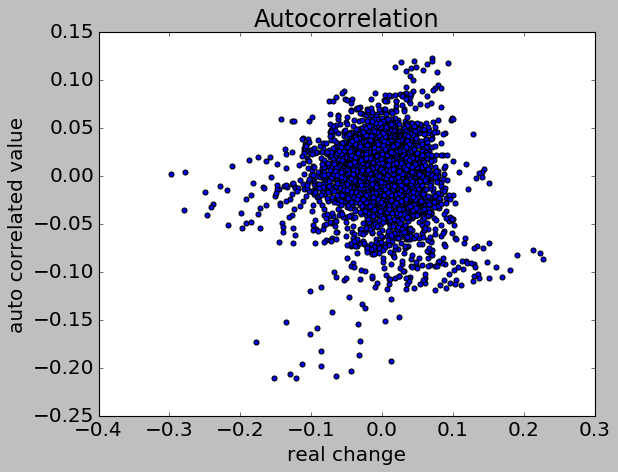

In [64]:
window_size = 1
look_forward =20
scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
MAs_scaled = scaler.fit_transform(MAs)
x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward, 1)
MAs_array = MAs.values
x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward, 1)
y1, y2 = benchmark(y,look_forward)
plt.scatter(y1,y2)
plt.ylabel('auto correlated value')
plt.xlabel('real change')
plt.title('Autocorrelation')
print('r2_score = ', r2_score(y1,y2))

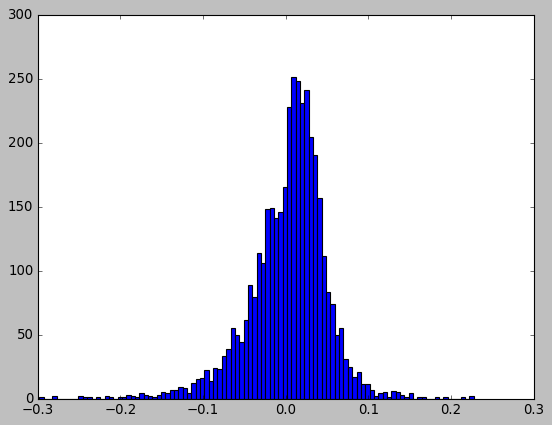

In [55]:
plt.hist(y1, bins = 100, edgecolor = 'black', histtype='bar');

# KNN Regression

In [31]:
train_ratio = 0.8
window_size = 1
look_forwards = [20]
batch_size = 16 

look_forward_table, time_table, smape_test, smape_train, mae_train, mae_test = [], [], [], [], [], []
K_value, mse_train, mse_test, r2_train, r2_test = [], [], [], [], []

for look_forward in look_forwards:
    start_time = time.time()
    scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
    MAs_scaled = scaler.fit_transform(MAs)
    x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
    MAs_array = MAs.values
    x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)

#split to train and CV
    x = x.reshape(len(x), -1)
    x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)

    for K in range(1,2):
        K = K+1
        K_value.append(K)
        model = neighbors.KNeighborsRegressor(n_neighbors = K)
        model.fit(x_train, y_train)  
        prediction_train = model.predict(x_train)
        prediction_test = model.predict(x_test)
        accuracy_train_smape = round(smape(prediction_train, y_train), 2)
        accuracy_test_smape = round(smape(prediction_test, y_test), 2)
        accuracy_train_mse = round(mse(prediction_train, y_train), 5)
        accuracy_test_mse = round(mse(prediction_test, y_test), 5)
        accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
        accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
        accuracy_train_mae = round(mae(prediction_train, y_train), 4)
        accuracy_test_mae = round(mae(prediction_test, y_test), 4)
        smape_train.append(accuracy_train_smape)
        smape_test.append(accuracy_test_smape)
        mse_train.append(accuracy_train_mse)
        mse_test.append(accuracy_test_mse)
        r2_train.append(accuracy_train_r2)
        r2_test.append(accuracy_test_r2)
        mae_train.append(accuracy_train_mae)
        mae_test.append(accuracy_test_mae)
        end_time = time.time()
        time_table.append(round(end_time - start_time,2))
        look_forward_table.append(look_forward)


hyper_parameters = pd.DataFrame(list(zip(K_value,look_forward_table, time_table, smape_train, smape_test, mae_train,
                                         mae_test, mse_train, mse_test, r2_train, r2_test)),
        columns =['k', 'look_forward', 'time', 'smape_train', 'smape_test',
                  'mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_train'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

,k,look_forward,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,2,20,0.11,57.12,136.43,0.0128,0.0227,0.00045,0.001,0.75,-1.65


<Figure size 640x480 with 0 Axes>

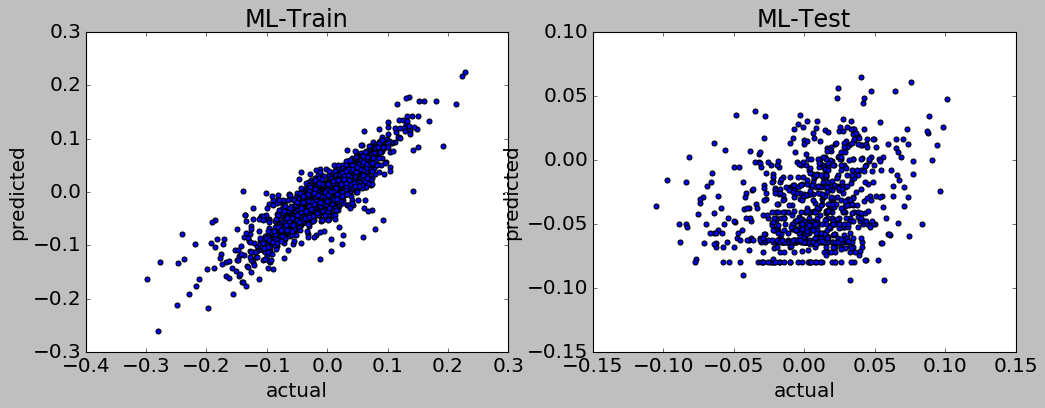

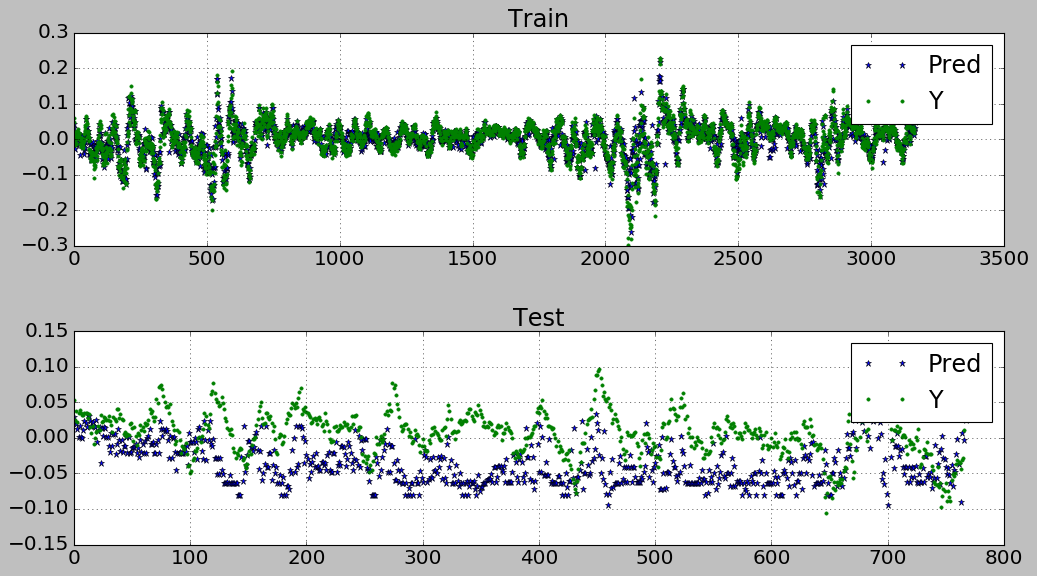

In [102]:
plot(y_train, prediction_train,y_test, prediction_test)

# KNN Classification

In [12]:
train_ratio = 0.8
window_size = 1
batch_size = 8

train = []
test = []
k = []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr, long_fscores =  [], [], [], [], [], []

look_forwards = [20]

for look_forward in look_forwards:
    start_time = time.time()
    scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
    MAs_scaled = scaler.fit_transform(MAs)
    x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
    MAs_array = MAs.values
    x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)
    y = y_classifier(y, 0.02)
    x = x.reshape(len(x), -1)
    x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)

    for K in range(58,59):
        K = K+1
        k.append(K)
        model = neighbors.KNeighborsClassifier(n_neighbors = K)
        model.fit(x_train, y_train)  
        prediction_train = model.predict(x_train)
        prediction_test = model.predict(x_test)
        rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                                    output_dict=True )
        long_precision =  rpt['long']['precision']
        long_fscore = rpt['long']['f1-score']
        cash_precision =  rpt['cash']['precision']
        short_precision =  rpt['short']['precision']
        long_rec =  rpt['long']['recall']
        cash_rec =  rpt['cash']['recall']
        short_rec =  rpt['short']['recall']
        rptt = classification_report(y_train, prediction_train, target_names = ['short','cash','long'], 
                                     output_dict=True )
        long_precision_t =  rptt['long']['precision']
        cash_precision_t =  rptt['cash']['precision']
        short_precision_t =  rptt['short']['precision']
        long_rec_t =  rptt['long']['recall']
        cash_rec_t =  rptt['cash']['recall']
        short_rec_t =  rptt['short']['recall']
        long_prec.append(long_precision)
        cash_prec.append(cash_precision)
        short_prec.append(short_precision)
        long_recal.append(long_rec)
        cash_recal.append(cash_rec)
        short_recal.append(short_rec)
        long_prec_tr.append(long_precision_t)
        cash_prec_tr.append(cash_precision_t)
        short_prec_tr.append(short_precision_t)
        long_recal_tr.append(long_rec_t)
        cash_recal_tr.append(cash_rec_t)
        short_recal_tr.append(short_rec_t)
        long_fscores.append(long_fscore)

hyper_parameters = pd.DataFrame(list(zip(k, long_fscores, long_prec, cash_prec, short_prec, long_prec_tr, 
cash_prec_tr, short_prec_tr )),columns =['K', 'long_fscore_test', 'long_prec',
'cash_prec', 'short_prec', 'long_prec_train', 'cash_prec_train', 'short_prec_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,K,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,59,0.48139,0.692857,0.638122,0.0,0.568082,0.507837,0.552987


In [22]:
hyper_parameters

,K,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,74,0.484262,0.666667,0.641457,0.000000,0.557541,0.496333,0.523596
1,67,0.484108,0.678082,0.639276,0.000000,0.560639,0.500615,0.549266
2,59,0.481390,0.692857,0.638122,0.000000,0.568082,0.507837,0.552987
3,72,0.480583,0.664430,0.640559,0.000000,0.562229,0.499389,0.534632
4,71,0.476886,0.662162,0.639665,0.000000,0.561912,0.498463,0.536017
5,69,0.475490,0.668966,0.638387,0.000000,0.563093,0.500612,0.534737
6,64,0.474074,0.676056,0.637119,0.000000,0.566203,0.505257,0.562500
7,61,0.474074,0.676056,0.637119,0.000000,0.565942,0.508105,0.552419
8,73,0.473171,0.659864,0.638773,0.000000,0.556908,0.496620,0.526316
9,65,0.472906,0.671329,0.638003,0.000000,0.565818,0.504627,0.553719


# KNN Test

In [24]:
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'] )
print(rpt)

              precision    recall  f1-score   support

       short       0.00      0.00      0.00       115
        cash       0.64      0.95      0.76       486
        long       0.69      0.37      0.48       263

   micro avg       0.65      0.65      0.65       864
   macro avg       0.44      0.44      0.42       864
weighted avg       0.57      0.65      0.58       864



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


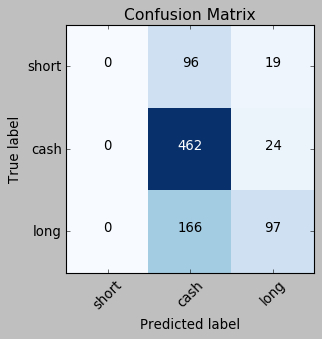

In [13]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test, prediction_test, classes= ['short', 'cash', 'long'],
                         normalize=False, title='Confusion Matrix')

# KNN Train:

In [26]:
rpt = classification_report(y_train, prediction_train, target_names = ['short', 'cash', 'long'] )
print(rpt)

              precision    recall  f1-score   support

       short       0.55      0.31      0.40       914
        cash       0.51      0.64      0.57      1258
        long       0.57      0.59      0.58      1308

   micro avg       0.54      0.54      0.54      3480
   macro avg       0.54      0.52      0.52      3480
weighted avg       0.54      0.54      0.53      3480



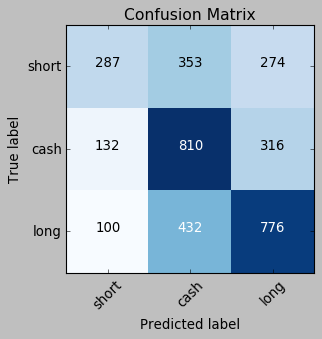

In [27]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_train, prediction_train, classes= ['short', 'cash', 'long'],
                         normalize=False, title='Confusion Matrix')

# Classification for  Benchmark

In [15]:
window_size = 1
look_forward =20
train_ratio = 0.8
MAs_array = MAs.values
x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward, 1)
test_y = y[int(len(y)*train_ratio):,:]
y1, y2 = benchmark(test_y,look_forward)
y1, y2 = y_classifier(y1.reshape(-1,1), 0.02), y_classifier(y2.reshape(-1,1), 0.02)


In [19]:
rpt = classification_report(y1, y2, target_names = ['short', 'cash', 'long'] )
print(rpt)

              precision    recall  f1-score   support

       short       0.08      0.05      0.06       115
        cash       0.56      0.64      0.60       471
        long       0.07      0.07      0.07       243

   micro avg       0.39      0.39      0.39       829
   macro avg       0.24      0.25      0.24       829
weighted avg       0.35      0.39      0.37       829



In [50]:
import itertools 
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y1, y2, classes= ['short', 'cash', 'long'],
                         normalize=False, title='Confusion Matrix')

ValueError: continuous is not supported

<Figure size 320x320 with 0 Axes>

# SVM Regressor

In [26]:
train_ratio = 0.8
batch_size = 8
kernels = ['poly']  
look_forward = 20
window_size = 1
Cs = [5]
gammas = [4]
degrees = [3]
look_forwards = [20]
K, Ct, G, D, LF = [], [], [], [], []
time_table, epoch_table, epoch_table, smape_test,smape_train, mae_train, mae_test, mse_train, mse_test, r2_train, r2_test = [], [], [], [], [], [], [], [], [], [], []

for kernel in kernels:
    for c in Cs:
        for d in degrees:
            for g in gammas:
                for look_forward in look_forwards:
                    start_time = time.time()
                    
                    scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                    MAs_scaled = scaler.fit_transform(MAs)
                    x, y_scaled = create_dataset_difference_gap(MAs_scaled, 1, look_forward,1)
                    MAs_array = MAs.values
                    x_scaled, y = create_dataset_difference_gap(MAs_array, 1, look_forward,1)
                    y = y.ravel()
                    x = x.reshape(len(x), -1)
                    x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)

                    model = SVR(kernel = kernel, C = c, degree = d, gamma = g)
                    model.fit(x_train, y_train)  
                    prediction_train = model.predict(x_train)
                    prediction_test = model.predict(x_test)
                    accuracy_train_smape = round(smape(prediction_train, y_train), 2)
                    accuracy_test_smape = round(smape(prediction_test, y_test), 2)
                    accuracy_train_mse = round(mse(prediction_train, y_train), 5)
                    accuracy_test_mse = round(mse(prediction_test, y_test), 5)
                    accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
                    accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
                    accuracy_train_mae = round(mae(prediction_train, y_train), 4)
                    accuracy_test_mae = round(mae(prediction_test, y_test), 4)
                    smape_train.append(accuracy_train_smape)
                    smape_test.append(accuracy_test_smape)
                    mse_train.append(accuracy_train_mse)
                    mse_test.append(accuracy_test_mse)
                    r2_train.append(accuracy_train_r2)
                    r2_test.append(accuracy_test_r2)
                    mae_train.append(accuracy_train_mae)
                    mae_test.append(accuracy_test_mae)
                    end_time = time.time()
                    time_table.append(round(end_time - start_time,2))
                    K.append(kernel)
                    Ct.append(c)
                    G.append(g)
                    D.append(d)
                    LF.append(look_forward)
                    print(round(end_time - start_time,2), kernel, c, g, d, look_forward)
hyper_parameters = pd.DataFrame(list(zip(K, Ct, G, D, LF, time_table, smape_train, smape_test, mae_train,
                                         mae_test, mse_train, mse_test, r2_train, r2_test)),
        columns =['kernel', 'C', 'gamma', 'degree', 'look_forward', 'time', 'smape_train', 'smape_test',
                  'mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_train'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

17.49 poly 5 4 3 20


,kernel,C,gamma,degree,look_forward,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,poly,5,4,3,20,17.49,118.13,116.71,3.5807,5.9705,25.64781,64.24178,-3.17,-3.75


In [28]:
hyper_parameters 

,kernel,C,gamma,degree,look_forward,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,poly,5,4,3,20,17.49,118.13,116.71,3.5807,5.9705,25.64781,64.24178,-3.17,-3.75


<Figure size 640x480 with 0 Axes>

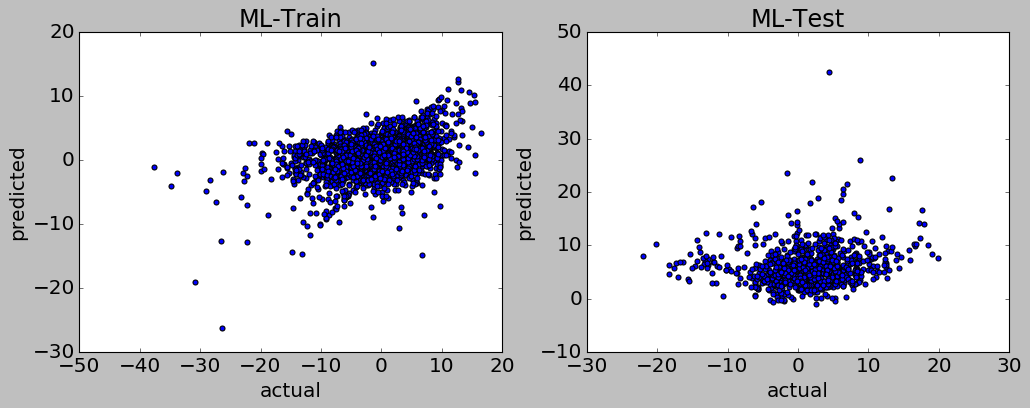

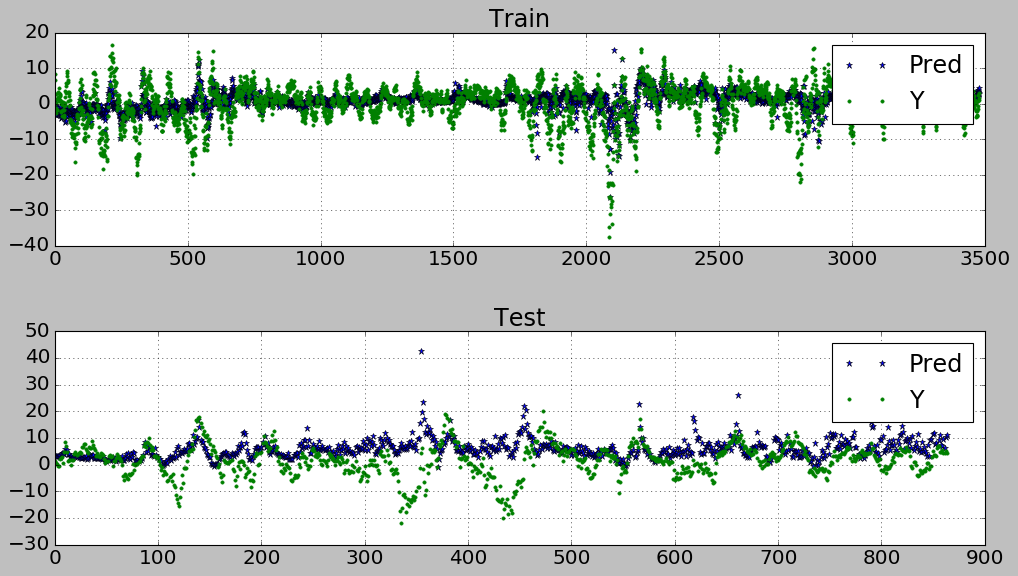

In [27]:
plot(y_train, prediction_train,y_test, prediction_test)

# SVM Classifier

In [6]:
train_ratio = 0.8
batch_size = 8
kernels = ['poly']  
Cs = [0.35]
gammas = [3.25]
degrees = [3]
look_forwards = [20]
K, Ct, G, D, LF = [], [], [], [], []
time_table = []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr, long_fscores =  [], [], [], [], [], []

for kernel in kernels:
    for c in Cs:
        for d in degrees:
            for g in gammas:
                for look_forward in look_forwards:
                    start_time = time.time()
                    scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                    MAs_scaled = scaler.fit_transform(MAs)
                    x, y_scaled = create_dataset_percentage_gap(MAs_scaled, 1, look_forward,1)
                    MAs_array = MAs.values
                    x_scaled, y = create_dataset_percentage_gap(MAs_array, 1, look_forward,1)
                    y = y_classifier(y, 0.02)
                    #y = y.ravel()
                    x = x.reshape(len(x), -1)
                    x_train, y_train, x_test, y_test = test_train(x, y, batch_size, train_ratio)
                    
                    model = SVC(kernel = kernel, C = c, degree = d, gamma = g)
                    model.fit(x_train, y_train)  
                    prediction_train = model.predict(x_train)
                    prediction_test = model.predict(x_test)
                    rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                                    output_dict=True )
                    long_precision =  rpt['long']['precision']
                    long_fscore = rpt['long']['f1-score']
                    cash_precision =  rpt['cash']['precision']
                    short_precision =  rpt['short']['precision']
                    long_rec =  rpt['long']['recall']
                    cash_rec =  rpt['cash']['recall']
                    short_rec =  rpt['short']['recall']
                    rptt = classification_report(y_train, prediction_train, target_names = ['short','cash','long'], 
                                                 output_dict=True )
                    long_precision_t =  rptt['long']['precision']
                    cash_precision_t =  rptt['cash']['precision']
                    short_precision_t =  rptt['short']['precision']
                    long_rec_t =  rptt['long']['recall']
                    cash_rec_t =  rptt['cash']['recall']
                    short_rec_t =  rptt['short']['recall']
                    long_prec.append(long_precision)
                    cash_prec.append(cash_precision)
                    short_prec.append(short_precision)
                    long_recal.append(long_rec)
                    cash_recal.append(cash_rec)
                    short_recal.append(short_rec)
                    long_prec_tr.append(long_precision_t)
                    cash_prec_tr.append(cash_precision_t)
                    short_prec_tr.append(short_precision_t)
                    long_recal_tr.append(long_rec_t)
                    cash_recal_tr.append(cash_rec_t)
                    short_recal_tr.append(short_rec_t)
                    long_fscores.append(long_fscore)
                    end_time = time.time()
                    time_table.append(round(end_time - start_time,2))
                    K.append(kernel)
                    Ct.append(c)
                    G.append(g)
                    D.append(d)
                    LF.append(look_forward)
                    print(round(end_time - start_time,2), kernel, c, g, d, look_forward, long_fscore)
hyper_parameters = pd.DataFrame(list(zip(K, Ct, G, D, LF, time_table, long_fscores, long_prec, cash_prec, short_prec, long_prec_tr, 
cash_prec_tr, short_prec_tr )),
columns =['kernel', 'C', 'gamma', 'degree', 'look_forward', 'time', 'long_fscore_test', 'long_prec',
'cash_prec', 'short_prec', 'long_prec_train', 'cash_prec_train', 'short_prec_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

1.67 poly 0.35 3.25 3 20 0.5531197301854974


,kernel,C,gamma,degree,look_forward,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,poly,0.35,3.25,3,20,1.67,0.55312,0.49697,0.694184,0.0,0.516505,0.490458,0.559229


In [14]:
hyper_parameters

,kernel,C,gamma,degree,look_forward,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,poly,0.35,3.0,3,20,1.43,0.550918,0.491071,0.694497,0.0,0.513251,0.487713,0.560694
1,poly,0.65,2.5,3,20,1.48,0.550918,0.491071,0.693182,0.0,0.514582,0.488959,0.562500
2,poly,0.50,3.0,3,20,1.74,0.549747,0.493939,0.692884,0.0,0.518519,0.492994,0.560647
3,poly,0.50,2.5,3,20,1.30,0.542955,0.495298,0.691743,0.0,0.509904,0.482500,0.568254
4,poly,0.35,3.5,3,20,1.72,0.540816,0.489231,0.686456,0.0,0.519193,0.494238,0.569554
5,poly,0.35,2.5,3,20,1.14,0.536013,0.479042,0.690566,0.0,0.505784,0.476190,0.555944
6,poly,0.65,3.0,3,20,1.79,0.531732,0.484375,0.683241,0.0,0.526488,0.497433,0.572519
7,poly,0.50,3.5,3,20,2.26,0.520070,0.480645,0.676895,0.0,0.530026,0.501624,0.584352
8,poly,0.65,3.5,3,20,2.55,0.496324,0.480427,0.665523,0.0,0.533333,0.507591,0.583908


In [17]:
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'] )
print(rpt)

              precision    recall  f1-score   support

       short       0.00      0.00      0.00       115
        cash       0.69      0.76      0.73       486
        long       0.50      0.62      0.55       263

   micro avg       0.62      0.62      0.62       864
   macro avg       0.40      0.46      0.43       864
weighted avg       0.54      0.62      0.58       864



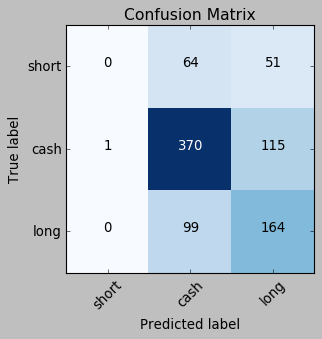

In [18]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test, prediction_test, classes= ['short', 'cash', 'long'],
                         normalize=False, title='Confusion Matrix')

# Random Forest Regresor

In [39]:
train_ratio = 0.8
batch_size = 8
look_forward = 20
n_estimators, max_depths, min_samples_split, min_samples_leaf = [50], [100], [5], [4]
n_estimatorsl, max_depthl, min_samples_splitl, min_samples_leafl = [], [], [], []
time_table, smape_train, smape_test, mae_train, mae_test = [], [], [], [], []
mse_train, mse_test, r2_train, r2_test = [],[], [], []

for estimators in n_estimators:   
    for max_depth in max_depths:
        for min_sample_split in min_samples_split:
            for min_sample_leaf in min_samples_leaf:
                start_time = time.time()
                scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                MAs_scaled = scaler.fit_transform(MAs)
                x, y_scaled = create_dataset_percentage_gap(MAs_scaled, 1, look_forward,1)
                MAs_array = MAs.values
                x_scaled, y = create_dataset_percentage_gap(MAs_array, 1, look_forward,1)
                y = y.ravel()
                x = x.reshape(len(x), -1)
                x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)
                model = RandomForestRegressor(n_estimators = estimators, max_depth = max_depth,
                   min_samples_split = min_sample_split, min_samples_leaf = min_sample_leaf, random_state = 413)
                model.fit(x_train, y_train)  
                prediction_train = model.predict(x_train)
                prediction_test = model.predict(x_test)
                accuracy_train_smape = round(smape(prediction_train, y_train), 2)
                accuracy_test_smape = round(smape(prediction_test, y_test), 2)
                accuracy_train_mse = round(mse(prediction_train, y_train), 5)
                accuracy_test_mse = round(mse(prediction_test, y_test), 5)
                accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
                accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
                accuracy_train_mae = round(mae(prediction_train, y_train), 4)
                accuracy_test_mae = round(mae(prediction_test, y_test), 4)
                smape_train.append(accuracy_train_smape)
                smape_test.append(accuracy_test_smape)
                mse_train.append(accuracy_train_mse)
                mse_test.append(accuracy_test_mse)
                r2_train.append(accuracy_train_r2)
                r2_test.append(accuracy_test_r2)
                mae_train.append(accuracy_train_mae)
                mae_test.append(accuracy_test_mae)
                end_time = time.time()
                time_table.append(round(end_time - start_time,2))
                n_estimatorsl.append(estimators)
                max_depthl.append(max_depth)
                min_samples_splitl.append(min_sample_split)
                min_samples_leafl.append(min_sample_leaf)

                print(round(end_time - start_time,2),estimators, max_depth, min_sample_split, min_sample_leaf, 
                      accuracy_test_r2, accuracy_test_mse )
hyper_parameters = pd.DataFrame(list(zip(n_estimatorsl, max_depthl, min_samples_splitl, min_samples_leafl
                                         , time_table, smape_train, smape_test, mae_train,
                                         mae_test, mse_train, mse_test, r2_train, r2_test)),
        columns =['n_estimators',' max_depths', 'min_samples_split', 'min_samples_leaf', 'time', 'smape_train'
                  , 'smape_test','mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_test'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

1.48 50 100 5 4 -4.0 0.00097


,n_estimators,max_depths,min_samples_split,min_samples_leaf,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,50,100,5,4,1.48,56.78,126.88,0.0126,0.022,0.00035,0.00097,0.72,-4.0


In [35]:
hyper_parameters

,n_estimators,max_depths,min_samples_split,min_samples_leaf,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,50,100,5,4,1.43,56.78,126.88,0.0126,0.0220,0.00035,0.00097,0.72,-4.00
1,50,100,2,4,1.44,56.78,126.88,0.0126,0.0220,0.00035,0.00097,0.72,-4.00
2,100,100,5,4,2.81,55.70,128.13,0.0124,0.0222,0.00034,0.00099,0.73,-4.26
3,100,100,2,4,2.88,55.70,128.13,0.0124,0.0222,0.00034,0.00099,0.73,-4.26
4,50,100,2,1,1.71,38.92,128.62,0.0081,0.0224,0.00014,0.00101,0.91,-3.95
5,50,100,5,1,1.59,42.37,128.63,0.0090,0.0223,0.00018,0.00100,0.88,-4.01
6,100,100,2,1,3.40,37.86,130.20,0.0079,0.0227,0.00013,0.00102,0.92,-4.28
7,100,100,5,1,3.16,41.76,131.11,0.0089,0.0226,0.00018,0.00101,0.88,-4.38
8,10,100,2,4,0.31,59.75,132.58,0.0131,0.0227,0.00040,0.00099,0.70,-3.78
9,10,100,5,4,0.32,59.75,132.58,0.0131,0.0227,0.00040,0.00099,0.70,-3.78


In [37]:
hyper_parameters

,n_estimators,max_depths,min_samples_split,min_samples_leaf,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,100,70,5,4,2.84,55.70,128.13,0.0124,0.0222,0.00034,0.00099,0.73,-4.26
1,100,200,8,4,2.82,55.70,128.13,0.0124,0.0222,0.00034,0.00099,0.73,-4.26
2,100,70,8,4,2.98,55.70,128.13,0.0124,0.0222,0.00034,0.00099,0.73,-4.26
3,100,100,5,4,2.85,55.70,128.13,0.0124,0.0222,0.00034,0.00099,0.73,-4.26
4,100,100,8,4,2.87,55.70,128.13,0.0124,0.0222,0.00034,0.00099,0.73,-4.26
5,100,200,5,4,2.91,55.70,128.13,0.0124,0.0222,0.00034,0.00099,0.73,-4.26
6,100,200,5,6,2.72,66.70,128.94,0.0151,0.0220,0.00048,0.00098,0.56,-4.84
7,100,100,8,6,2.62,66.70,128.94,0.0151,0.0220,0.00048,0.00098,0.56,-4.84
8,100,200,8,6,2.62,66.70,128.94,0.0151,0.0220,0.00048,0.00098,0.56,-4.84
9,100,100,5,6,2.66,66.70,128.94,0.0151,0.0220,0.00048,0.00098,0.56,-4.84


<Figure size 640x480 with 0 Axes>

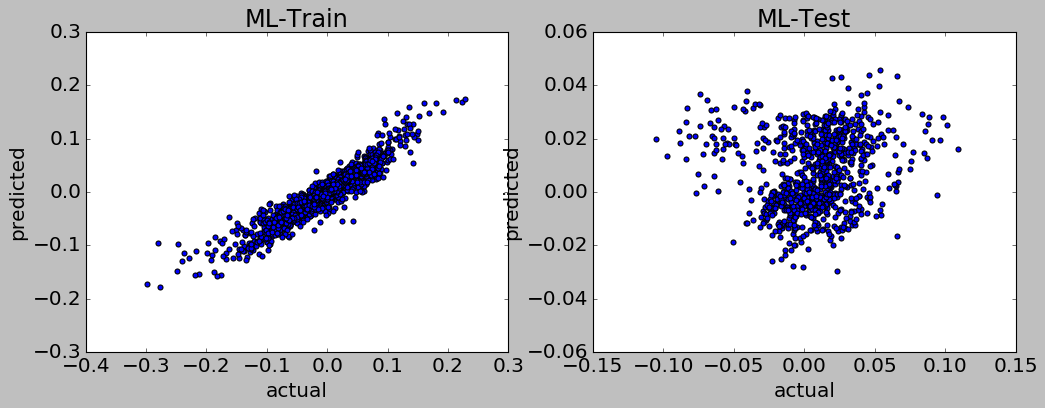

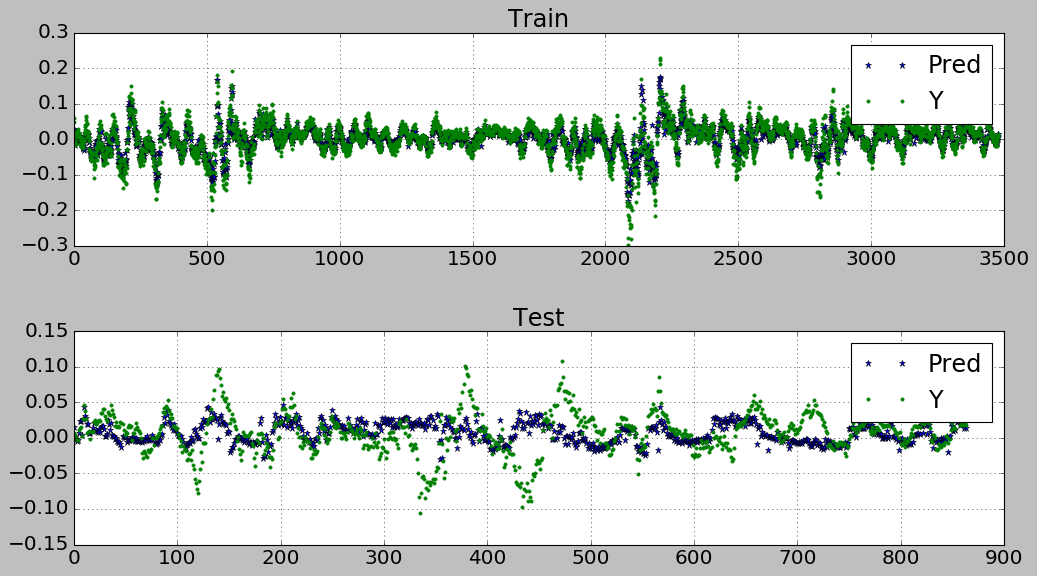

In [35]:
plot(y_train, prediction_train,y_test, prediction_test)

# Random Forest Classifier

In [57]:
train_ratio = 0.8
batch_size = 8
look_forward = 20
n_estimators, max_depths, min_samples_split, min_samples_leaf = [12], [40], [10], [4]
n_estimatorsl, max_depthl, min_samples_splitl, min_samples_leafl, long_fscores = [], [], [], [], []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr =  [], [], [], [], []

for estimators in n_estimators:   
    for max_depth in max_depths:
        for min_sample_split in min_samples_split:
            for min_sample_leaf in min_samples_leaf:
                start_time = time.time()
                scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                MAs_scaled = scaler.fit_transform(MAs)
                x, y_scaled = create_dataset_percentage_gap(MAs_scaled, 1, look_forward,1)
                MAs_array = MAs.values
                x_scaled, y = create_dataset_percentage_gap(MAs_array, 1, look_forward,1)
                y = y_classifier(y, 0.02)
                x = x.reshape(len(x), -1)
                
                x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)
                model = RandomForestClassifier(n_estimators = estimators, max_depth = max_depth,
                   min_samples_split = min_sample_split, min_samples_leaf = min_sample_leaf, random_state = 413)
                model.fit(x_train, y_train)  
                prediction_train = model.predict(x_train)
                prediction_test = model.predict(x_test)
                rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                                    output_dict=True )
                long_precision =  rpt['long']['precision']
                long_fscore = rpt['long']['f1-score']
                cash_precision =  rpt['cash']['precision']
                short_precision =  rpt['short']['precision']
                long_rec =  rpt['long']['recall']
                cash_rec =  rpt['cash']['recall']
                short_rec =  rpt['short']['recall']
                rptt = classification_report(y_train, prediction_train, target_names = ['short','cash','long'], 
                                             output_dict=True )
                long_precision_t =  rptt['long']['precision']
                cash_precision_t =  rptt['cash']['precision']
                short_precision_t =  rptt['short']['precision']
                long_rec_t =  rptt['long']['recall']
                cash_rec_t =  rptt['cash']['recall']
                short_rec_t =  rptt['short']['recall']
                long_prec.append(long_precision)
                cash_prec.append(cash_precision)
                short_prec.append(short_precision)
                long_recal.append(long_rec)
                cash_recal.append(cash_rec)
                short_recal.append(short_rec)
                long_prec_tr.append(long_precision_t)
                cash_prec_tr.append(cash_precision_t)
                short_prec_tr.append(short_precision_t)
                long_recal_tr.append(long_rec_t)
                cash_recal_tr.append(cash_rec_t)
                short_recal_tr.append(short_rec_t)
                long_fscores.append(long_fscore)
                n_estimatorsl.append(estimators)
                max_depthl.append(max_depth)
                min_samples_splitl.append(min_sample_split)
                time_table.append(round(end_time - start_time,2))
                min_samples_leafl.append(min_sample_leaf)
                print(round(end_time - start_time,2),estimators, max_depth, min_sample_split, min_sample_leaf, 
                      long_fscore)
hyper_parameters = pd.DataFrame(list(zip(n_estimatorsl, max_depthl, min_samples_splitl, min_samples_leafl
, time_table,long_fscores, long_prec, cash_prec, short_prec, long_prec_tr, cash_prec_tr, short_prec_tr  )),
columns =['n_estimators',' max_depths', 'min_samples_split', 'min_samples_leaf', 'time', 'long_fscore_test',
'long_prec','cash_prec', 'short_prec', 'long_prec_train', 'cash_prec_train', 'short_prec_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

-1340.45 12 40 10 4 0.5749613601236476


,n_estimators,max_depths,min_samples_split,min_samples_leaf,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,12,40,10,4,1.48,0.574961,0.484375,0.723356,0.102564,0.918675,0.890432,0.940421


In [55]:
hyper_parameters

,n_estimators,max_depths,min_samples_split,min_samples_leaf,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,12,40,10,4,-454.09,0.574961,0.484375,0.723356,0.102564,0.918675,0.890432,0.940421
1,30,8,6,4,-454.51,0.561644,0.510903,0.701107,0.000000,0.713043,0.695853,0.808199
2,30,8,10,4,-454.89,0.561576,0.494220,0.704854,0.000000,0.695244,0.668613,0.828201
3,12,40,6,8,-453.91,0.560117,0.455847,0.729730,0.133333,0.816011,0.811456,0.864831
4,12,40,10,8,-454.30,0.560117,0.455847,0.729730,0.133333,0.816011,0.811456,0.864831
5,30,16,6,4,-455.29,0.558214,0.480769,0.706263,0.081081,0.940299,0.936458,0.968218
6,12,8,6,8,-295.24,0.556270,0.481894,0.709091,0.200000,0.674247,0.636842,0.764885
7,12,8,10,8,-452.89,0.556270,0.481894,0.709091,0.200000,0.674247,0.636842,0.764885
8,12,8,10,4,-452.71,0.552716,0.476584,0.702306,0.125000,0.704782,0.659667,0.795732
9,30,40,6,8,-456.36,0.552167,0.477778,0.715464,0.105263,0.851033,0.836863,0.912718


In [58]:
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'] )
print(rpt)

              precision    recall  f1-score   support

       short       0.10      0.03      0.05       115
        cash       0.72      0.66      0.69       486
        long       0.48      0.71      0.57       263

   micro avg       0.59      0.59      0.59       864
   macro avg       0.44      0.47      0.44       864
weighted avg       0.57      0.59      0.57       864



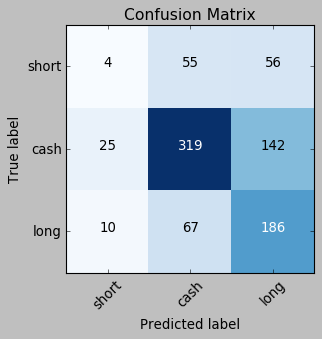

In [59]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test, prediction_test, classes= ['short', 'cash', 'long'],
                         normalize=False, title='Confusion Matrix')

# Neural Net Regressor

W1105 12:46:45.300885 10436 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1105 12:46:45.314042 10436 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1105 12:46:45.318056 10436 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1105 12:46:45.318056 10436 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1105 12:46:45.446222 10436 deprecation_wrapper.py:119] From C:\ProgramData\Anac

1 out of  12 units =  10 lr =  3e-07 batch_size =  32 epoch =  300
0.043 0.0774 19.17


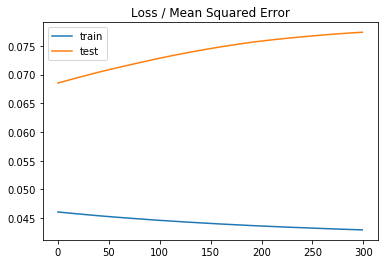

2 out of  12 units =  10 lr =  3e-07 batch_size =  128 epoch =  300
0.0443 0.0726 5.51


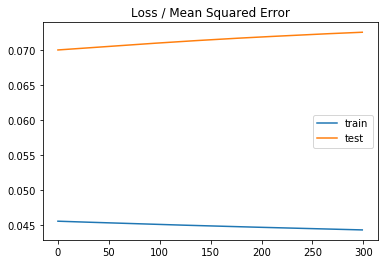

3 out of  12 units =  10 lr =  3e-05 batch_size =  32 epoch =  300
0.0353 0.0292 20.03


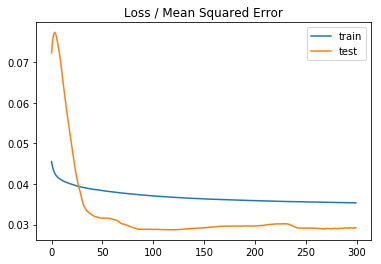

4 out of  12 units =  10 lr =  3e-05 batch_size =  128 epoch =  300
0.0363 0.0363 5.59


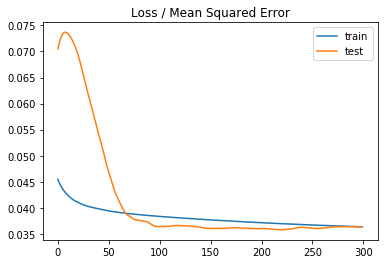

5 out of  12 units =  20 lr =  3e-07 batch_size =  32 epoch =  300
0.0758 0.1404 20.33


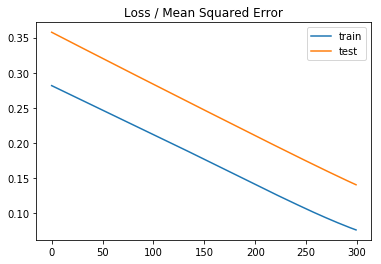

6 out of  12 units =  20 lr =  3e-07 batch_size =  128 epoch =  300
0.2289 0.3025 6.35


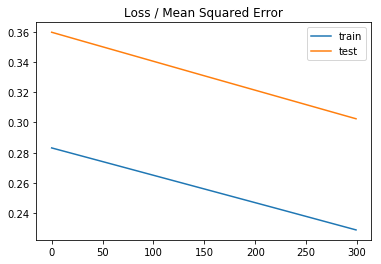

7 out of  12 units =  20 lr =  3e-05 batch_size =  32 epoch =  300
0.0361 0.0242 20.67


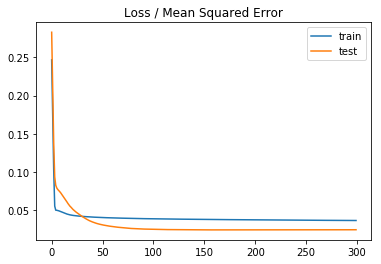

8 out of  12 units =  20 lr =  3e-05 batch_size =  128 epoch =  300
0.0374 0.0278 6.43


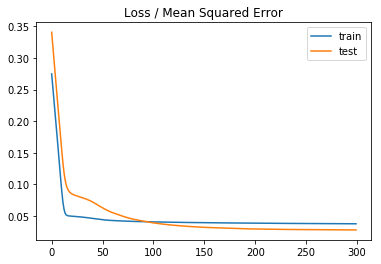

9 out of  12 units =  40 lr =  3e-07 batch_size =  32 epoch =  300
0.053 0.062 21.48


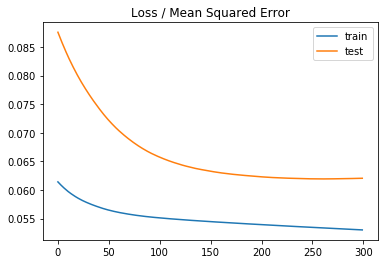

10 out of  12 units =  40 lr =  3e-07 batch_size =  128 epoch =  300
0.0548 0.0636 6.32


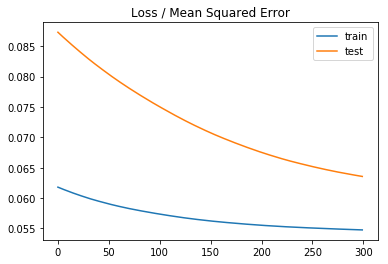

11 out of  12 units =  40 lr =  3e-05 batch_size =  32 epoch =  300
0.0335 0.0263 23.24


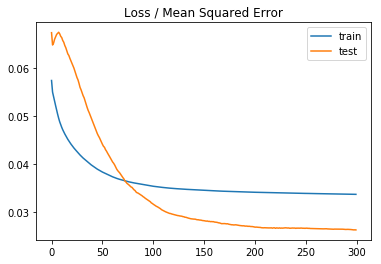

12 out of  12 units =  40 lr =  3e-05 batch_size =  128 epoch =  300
0.034 0.0271 7.14


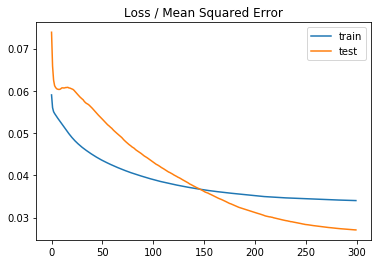

,unit,lr,batch_size,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,20,3.000000e-05,128,6.43,140.90,131.21,0.0374,0.0278,0.00271,0.00138,-4.20,-2.33
1,10,3.000000e-05,128,5.59,140.17,132.00,0.0363,0.0363,0.00281,0.00206,-6.21,-3.80
2,10,3.000000e-05,32,20.03,136.71,135.41,0.0353,0.0292,0.00259,0.00139,-14.25,-2.69
3,20,3.000000e-05,32,20.67,140.03,141.09,0.0361,0.0242,0.00256,0.00103,-7.01,-3.40
4,10,3.000000e-07,32,19.17,149.77,147.07,0.0430,0.0774,0.00363,0.00743,-2.17,-8.65
5,10,3.000000e-07,128,5.51,149.80,147.51,0.0443,0.0726,0.00362,0.00656,-2.00,-10.44
6,40,3.000000e-07,128,6.32,142.45,157.65,0.0548,0.0636,0.00690,0.00575,-0.45,-10.40
7,40,3.000000e-05,128,7.14,135.63,158.33,0.0340,0.0271,0.00237,0.00127,-9.62,-11.10
8,40,3.000000e-05,32,23.24,129.66,160.82,0.0335,0.0263,0.00231,0.00110,-15.16,-14.90
9,40,3.000000e-07,32,21.48,140.83,163.22,0.0530,0.0620,0.00646,0.00521,-0.47,-10.80


In [5]:
train_ratio = 0.8
window_size = 1
look_forward =20

unit_table = []
lr_table = []
batch_size_table = []
time_table, epoch_table, smape_test, smape_train, mae_train = [], [], [], [], []
mae_test, mse_train, mse_test, r2_train, r2_test = [], [], [], [], []

Units = [ 10, 20, 40]
lrs = [0.0000003, 0.00003]
batch_sizes = [32, 128]
epochs = 300
counter = 0
for units in Units:
    for lr in lrs:
        for batch_size in batch_sizes:
            total = len(Units)*len(lrs)*len(batch_sizes)
            counter += 1
            start_time = time.time()
            #fixing rnd
            fix_rnd_Keras()
            
            scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
            MAs_scaled = scaler.fit_transform(MAs)
            x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
            MAs_array = MAs.values
            x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)

            x = x.reshape(len(x), -1)
            x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)
            model = Sequential()
            model.add(Dense(units = units, activation = 'relu'))
            #model.add(Dropout(0.5))
            model.add(Dense(units = 1))
            opt = Adam(lr = lr)
            model.compile(loss = 'mae', optimizer = opt)
            history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                                epochs = epochs, batch_size = batch_size, verbose = 0, shuffle=False)

            print(counter, 'out of ', total, 'units = ', units, 'lr = ', lr, 
                  'batch_size = ', batch_size, 'epoch = ', epochs)

            unit_table.append(units)
            lr_table.append(lr)
            batch_size_table.append(batch_size)
            
            prediction_train = model.predict(x_train, batch_size=batch_size)
            prediction_test = model.predict(x_test, batch_size=batch_size)
            accuracy_train_smape = round(smape(prediction_train, y_train), 2)
            accuracy_test_smape = round(smape(prediction_test, y_test), 2)
            accuracy_train_mse = round(mse(prediction_train, y_train), 5)
            accuracy_test_mse = round(mse(prediction_test, y_test), 5)
            accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
            accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
            accuracy_train_mae = round(mae(prediction_train, y_train), 4)
            accuracy_test_mae = round(mae(prediction_test, y_test), 4)
            smape_train.append(accuracy_train_smape)
            smape_test.append(accuracy_test_smape)
            mse_train.append(accuracy_train_mse)
            mse_test.append(accuracy_test_mse)
            r2_train.append(accuracy_train_r2)
            r2_test.append(accuracy_test_r2)
            mae_train.append(accuracy_train_mae)
            mae_test.append(accuracy_test_mae)
            end_time = time.time()
            time_table.append(round(end_time - start_time,2))
            print(accuracy_train_mae, accuracy_test_mae, (round(end_time - start_time,2)))
            pyplot.title('Loss / Mean Squared Error')
            pyplot.plot(history.history['loss'], label='train')
            pyplot.plot(history.history['val_loss'], label='test')
            pyplot.legend()
            pyplot.show()
                    
hyper_parameters = pd.DataFrame(list(zip(unit_table,lr_table,batch_size_table,
    time_table, smape_train, smape_test, mae_train, mae_test, mse_train, mse_test, r2_train, r2_test)),
        columns =['unit','lr','batch_size','time','smape_train', 'smape_test',
                  'mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_test'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

In [97]:
hyper_parameters

,unit,lr,batch_size,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,20,3.000000e-05,64,48.45,139.22,128.16,0.0345,0.0259,0.00236,0.00118,-11.58,-3.58
1,20,3.000000e-05,32,95.21,135.61,140.60,0.0341,0.0239,0.00234,0.00102,-12.77,-3.56
2,20,3.000000e-05,128,25.54,140.32,140.65,0.0348,0.0260,0.00239,0.00121,-10.20,-3.77
3,20,3.000000e-07,32,100.64,140.76,145.09,0.0469,0.0704,0.00414,0.00612,-1.32,-10.98
4,20,3.000000e-07,64,50.63,139.41,151.24,0.0490,0.0812,0.00448,0.00784,-1.09,-12.42
5,20,1.000000e-07,32,101.29,136.12,162.98,0.0624,0.1213,0.00678,0.01597,-2.14,-28.25
6,20,3.000000e-07,128,26.62,148.20,171.81,0.1001,0.1705,0.01365,0.03041,-5.26,-55.54
7,20,1.000000e-07,64,51.91,163.26,178.83,0.1657,0.2365,0.03161,0.05718,-14.22,-108.40
8,20,1.000000e-07,128,27.36,171.35,182.13,0.2241,0.2974,0.05454,0.08979,-24.69,-172.37


In [102]:
hyper_parameters

,unit,lr,batch_size,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,20,3.000000e-07,32,226.39,136.23,174.86,0.0433,0.0985,0.0036,0.01125,-1.53,-8.78


<Figure size 640x480 with 0 Axes>

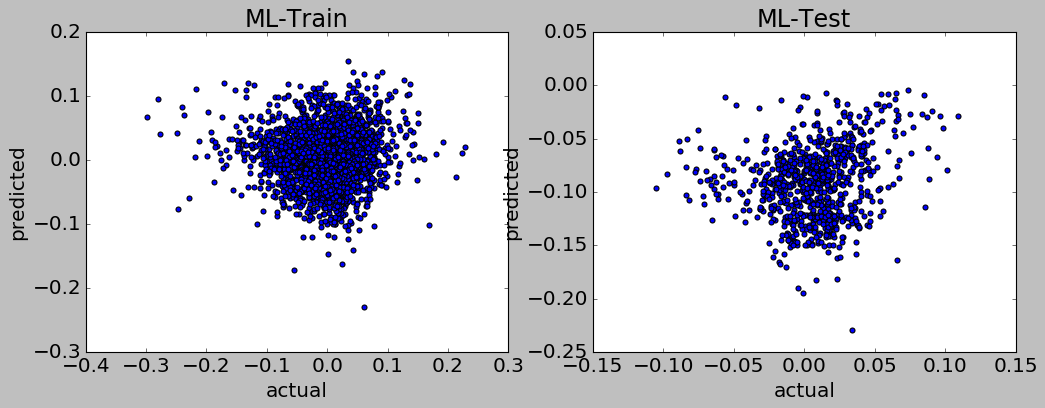

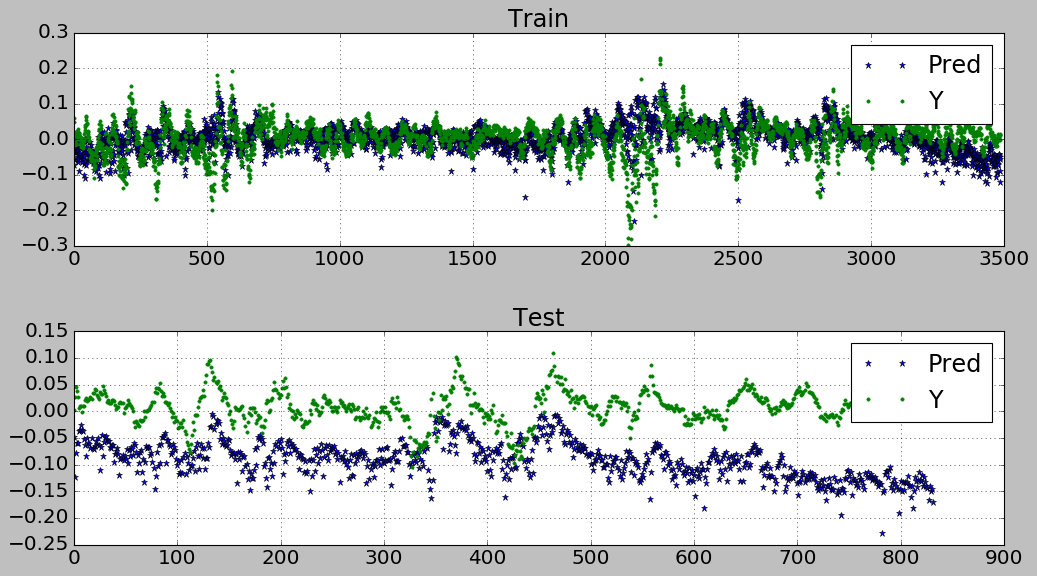

In [101]:
plot(y_train, prediction_train,y_test, prediction_test) # 1 layer, 20 units, drop out, 2000 epochs

# Neural Net Classifier

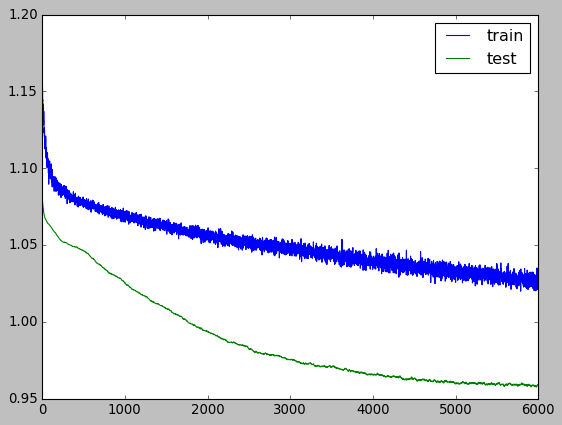

240.24 1 out of  1 units =  40 lr =  3e-05 batch_size =  256 epoch =  6000 long prec =  0.5842696629213483 fscore =  0.64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,unit,epoch,lr,batch,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,40,6000,0.00003,256,240.24,0.64,0.58427,0.640719,0.0,0.49168,0.517314,0.578431


In [63]:
train_ratio = 0.8
window_size = 1
look_forward =20

unit_table = []
lr_table = []
batch_size_table = []
time_table, epoch_table = [], []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr, long_fscores =  [], [], [], [], [], []

Units = [40]
lrs = [ 0.00003]
batch_sizes = [256]
epoch = [6000]
counter = 0
for units in Units:
    for lr in lrs:
        for batch_size in batch_sizes:
            for epochs in epoch:
                total = len(Units)*len(lrs)*len(batch_sizes)* len(epoch)
                counter += 1
                start_time = time.time()
                #fixing rnd
                fix_rnd_Keras()

                scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                MAs_scaled = scaler.fit_transform(MAs)
                x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                MAs_array = MAs.values
                x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)
                y = y_classifier(y, 0.02)
                y = y_softmax(y)
                x = x.reshape(len(x), -1)
                x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)

                model = Sequential()
                model.add(Dense(units = units, activation = 'relu'))
                model.add(Dropout(0.5))
                model.add(Dense(units = units, activation = 'relu'))
                model.add(Dropout(0.5))
                model.add(Dense(3, activation='softmax'))
                opt = Adam(lr = lr)
                model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
                history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                                    epochs = epochs, batch_size = batch_size, verbose = 0, shuffle=False)

                pyplot.plot(history.history['loss'], label='train')
                pyplot.plot(history.history['val_loss'], label='test')
                pyplot.legend()
                pyplot.show()
                unit_table.append(units)
                lr_table.append(lr)
                batch_size_table.append(batch_size)
                prediction_train = model.predict(x_train)
                prediction_test = model.predict(x_test)
                y_train, y_test, prediction_train, prediction_test = desoftmaxer(y_train), desoftmaxer(y_test),desoftmaxer(prediction_train), desoftmaxer(prediction_test)
                rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                            output_dict=True )
                long_precision =  rpt['long']['precision']
                long_fscore = rpt['long']['f1-score']
                cash_precision =  rpt['cash']['precision']
                short_precision =  rpt['short']['precision']
                long_rec =  rpt['long']['recall']
                cash_rec =  rpt['cash']['recall']
                short_rec =  rpt['short']['recall']
                rptt = classification_report(y_train, prediction_train, target_names = ['short', 'cash', 'long'], 
                                             output_dict=True )
                long_precision_t =  rptt['long']['precision']
                cash_precision_t =  rptt['cash']['precision']
                short_precision_t =  rptt['short']['precision']
                long_rec_t =  rptt['long']['recall']
                cash_rec_t =  rptt['cash']['recall']
                short_rec_t =  rptt['short']['recall']
                long_prec.append(long_precision)
                cash_prec.append(cash_precision)
                short_prec.append(short_precision)
                long_recal.append(long_rec)
                cash_recal.append(cash_rec)
                short_recal.append(short_rec)
                long_prec_tr.append(long_precision_t)
                cash_prec_tr.append(cash_precision_t)
                short_prec_tr.append(short_precision_t)
                long_recal_tr.append(long_rec_t)
                cash_recal_tr.append(cash_rec_t)
                short_recal_tr.append(short_rec_t)
                long_fscores.append(long_fscore)
                epoch_table.append(epochs)

                end_time = time.time()
                time_table.append(round(end_time - start_time,2))
                print(round(end_time - start_time,2), counter, 'out of ', total, 'units = ', units, 'lr = ', lr, 
    'batch_size = ', batch_size, 'epoch = ', epochs,'long prec = ', long_precision, 'fscore = ', long_fscore)
            
hyper_parameters = pd.DataFrame(list(zip(unit_table, epoch_table, lr_table, batch_size_table, time_table, long_fscores, long_prec, 
            cash_prec, short_prec, long_prec_tr, cash_prec_tr, short_prec_tr )),
            columns =['unit', 'epoch', 'lr', 'batch', 'time', 'long_fscore_test', 'long_prec',
'cash_prec', 'short_prec', 'long_prec_train', 'cash_prec_train', 'short_prec_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters


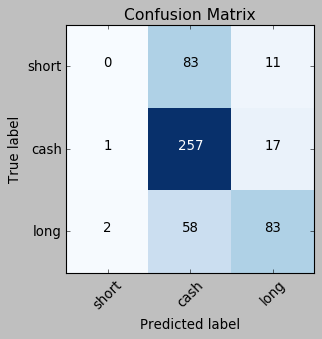

In [19]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test,prediction_test, classes= ['short', 'cash', 'long'],
normalize=False, title='Confusion Matrix')

In [20]:
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'])
print(rpt)

              precision    recall  f1-score   support

       short       0.00      0.00      0.00        94
        cash       0.65      0.93      0.76       275
        long       0.75      0.58      0.65       143

   micro avg       0.66      0.66      0.66       512
   macro avg       0.46      0.50      0.47       512
weighted avg       0.56      0.66      0.59       512



# Train confusion

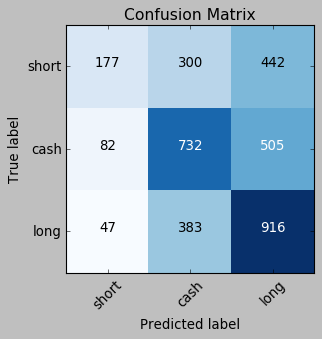

In [66]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_train,prediction_train, classes= ['short', 'cash', 'long'],
normalize=False, title='Confusion Matrix')

In [67]:
rpt = classification_report(y_train, prediction_train, target_names = ['short', 'cash', 'long'])
print(rpt)

              precision    recall  f1-score   support

       short       0.58      0.19      0.29       919
        cash       0.52      0.55      0.54      1319
        long       0.49      0.68      0.57      1346

   micro avg       0.51      0.51      0.51      3584
   macro avg       0.53      0.48      0.47      3584
weighted avg       0.52      0.51      0.49      3584



# LSTM Regressor

1 out of  1 units =  10 lr =  6e-07 look_forward = 20 window_size = 20 batch_size =  32 epoch =  80
0.0506 0.0826 67.43


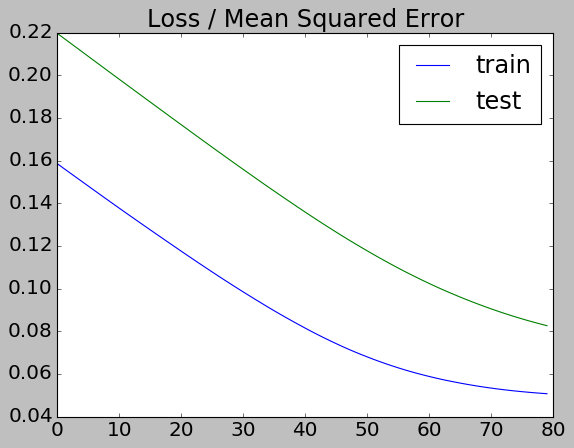

,unit,lr,window_size,batch_size,time,epoch,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,10,6.000000e-07,20,32,67.43,80,139.49,148.67,0.0506,0.0826,0.0046,0.00889,-1.56,-5.31


In [35]:
train_ratio = 0.8

unit_table = []
lr_table = []
batch_size_table = []

unit_table = []
lr_table = []
batch_size_table = []
time_table, epoch_table, smape_test, smape_train, mae_train, window_size_table = [], [], [], [], [], []
mae_test, mse_train, mse_test, r2_train, r2_test = [], [], [], [], []

Units = [ 10]
lrs = [ 0.0000006]
look_forwards = [20]
window_sizes = [20]
batch_sizes = [32]
Epochs = [80]
counter = 0
for units in Units:
    for lr in lrs:
        for look_forward in look_forwards:
            for window_size in window_sizes:
                for batch_size in batch_sizes:
                    for epochs in Epochs:
                        total = len(Units)*len(lrs)*len(look_forwards)*len(window_sizes)*len(batch_sizes)
                        counter += 1
                        start_time = time.time()
                        
                        fix_rnd_Keras()
                        scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                        MAs_scaled = scaler.fit_transform(MAs)
                        x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                        MAs_array = MAs.values
                        x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)

                        train_length = int(len(x)*train_ratio)

                        for i in range(train_length, train_length+batch_size):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length = i
                                break
                        x_train = x[:train_length,:]
                        y_train = y[:train_length,:]

                        for i in range(len(x)-batch_size, len(x)):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length_test = i
                                break
                        x_test = x[train_length:train_length_test,:]
                        y_test = y[train_length:train_length_test,:]

                        model = Sequential()
                        model.add(LSTM(units = units, batch_input_shape=(batch_size, window_size, x_train.shape[2]), 
                        stateful=True))#, return_sequences = True))
                        #model.add(LSTM(units = units, batch_input_shape=(batch_size, window_size, x_train.shape[2])
                        #,stateful=True))

                        model.add(Dense(units = 1))
                        opt = Adam(lr = lr)
                        model.compile(loss = 'mae', optimizer = opt)
                        history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                                            epochs = epochs, batch_size = batch_size, verbose = 0, shuffle=False)

                        print(counter, 'out of ', total, 'units = ', units, 'lr = ', lr, 'look_forward =', look_forward,
                              'window_size =', window_size, 'batch_size = ', batch_size, 'epoch = ', epochs)

                        unit_table.append(units)
                        lr_table.append(lr)
                        window_size_table.append(window_size)
                        batch_size_table.append(batch_size)
                        epoch_table.append(epochs)

                        prediction_train = model.predict(x_train, batch_size=batch_size)
                        prediction_test = model.predict(x_test, batch_size=batch_size)
                        accuracy_train_smape = round(smape(prediction_train, y_train), 2)
                        accuracy_test_smape = round(smape(prediction_test, y_test), 2)
                        accuracy_train_mse = round(mse(prediction_train, y_train), 5)
                        accuracy_test_mse = round(mse(prediction_test, y_test), 5)
                        accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
                        accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
                        accuracy_train_mae = round(mae(prediction_train, y_train), 4)
                        accuracy_test_mae = round(mae(prediction_test, y_test), 4)
                        smape_train.append(accuracy_train_smape)
                        smape_test.append(accuracy_test_smape)
                        mse_train.append(accuracy_train_mse)
                        mse_test.append(accuracy_test_mse)
                        r2_train.append(accuracy_train_r2)
                        r2_test.append(accuracy_test_r2)
                        mae_train.append(accuracy_train_mae)
                        mae_test.append(accuracy_test_mae)
                        end_time = time.time()
                        time_table.append(round(end_time - start_time,2))
                        print(accuracy_train_mae, accuracy_test_mae, (round(end_time - start_time,2)))
                        pyplot.title('Loss / Mean Squared Error')
                        pyplot.plot(history.history['loss'], label='train')
                        pyplot.plot(history.history['val_loss'], label='test')
                        pyplot.legend()
                        pyplot.show()
                    
hyper_parameters = pd.DataFrame(list(zip(unit_table,lr_table,window_size_table,batch_size_table,
    time_table, epoch_table, smape_train, smape_test, mae_train, mae_test, mse_train, mse_test, r2_train, r2_test)),
        columns =['unit','lr','window_size','batch_size','time', 'epoch', 'smape_train', 'smape_test',
                  'mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_train'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

<Figure size 640x480 with 0 Axes>

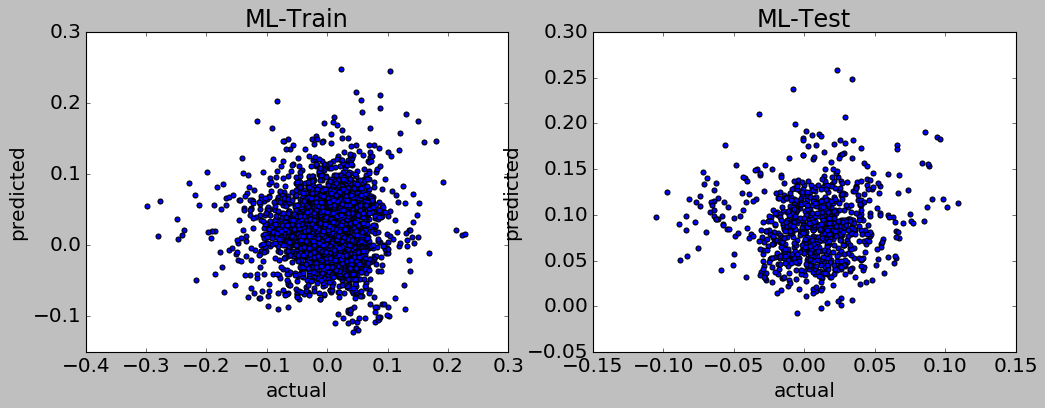

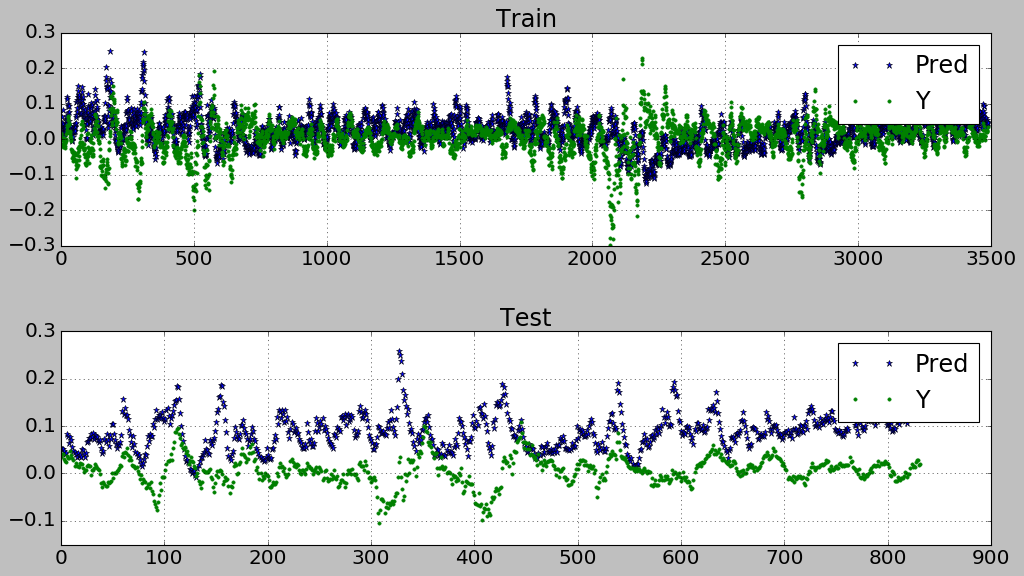

In [36]:
plot(y_train, prediction_train,y_test, prediction_test)

# LSTM Classify

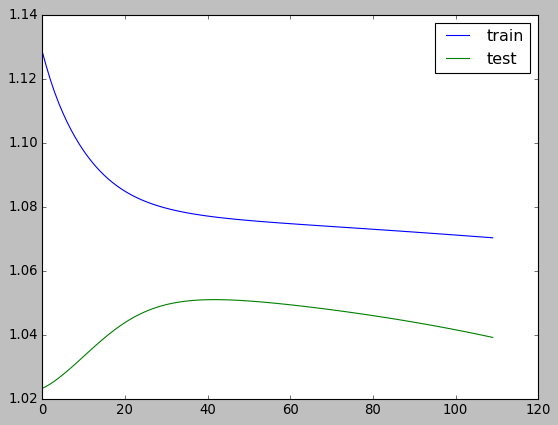

53.96 1 out of  1 units =  10 lr =  0.0001 batch_size =  256 epoch =  110 long prec =  0.6229508196721312 fscore =  0.6909090909090909


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,unit,epoch,lr,batch,time,long_fscore_test,long_prec,cash_prec,short_prec,fscore_train,cash_prec_train,short_prec_train
0,10,110,0.0001,256,53.96,0.690909,0.622951,0.656535,0.0,0.472547,0.448931,0.0


In [57]:
train_ratio = 0.8
window_size = 10
look_forward =20

unit_table = []
lr_table = []
batch_size_table = []
time_table, epoch_table = [], []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_trf =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr, long_fscores =  [], [], [], [], [], []

Units = [10]
lrs = [ 0.0001]
batch_sizes = [256]
epoch = [110]
counter = 0
for units in Units:
    for lr in lrs:
        for batch_size in batch_sizes:
            for epochs in epoch:
                total = len(Units)*len(lrs)*len(batch_sizes)* len(epoch)
                counter += 1
                start_time = time.time()
                #fixing rnd
                fix_rnd_Keras()

                scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                MAs_scaled = scaler.fit_transform(MAs)
                x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                MAs_array = MAs.values
                x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)
                y = y_classifier(y, 0.02)
                y = y_softmax(y)

                train_length = int(len(x)*train_ratio)

                for i in range(train_length, train_length+batch_size):
                    remainder = i%batch_size
                    if remainder == 0:
                        train_length = i
                        break
                x_train = x[:train_length,:]
                y_train = y[:train_length,]

                for i in range(len(x)-batch_size, len(x)):
                    remainder = i%batch_size
                    if remainder == 0:
                        train_length_test = i
                        break
                x_test = x[train_length:train_length_test,:]
                y_test = y[train_length:train_length_test,]

                model = Sequential()
                model.add(LSTM(units = units, batch_input_shape=(batch_size, window_size, x_train.shape[2]),
                               stateful=True))#, return_sequences = True))
                #model.add(LSTM(units = units, batch_input_shape=(batch_size, window_size, x_train.shape[2])
                #,stateful=True))
                model.add(Dense(3, activation='softmax'))
                opt = Adam(lr = lr)
                model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
                history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                                    epochs = epochs, batch_size = batch_size, verbose = 0, shuffle=False)

                pyplot.plot(history.history['loss'], label='train')
                pyplot.plot(history.history['val_loss'], label='test')
                pyplot.legend()
                pyplot.show()
                unit_table.append(units)
                lr_table.append(lr)
                batch_size_table.append(batch_size)
                prediction_train = model.predict(x_train, batch_size=batch_size)
                prediction_test = model.predict(x_test, batch_size=batch_size)
                y_train, y_test, prediction_train, prediction_test = desoftmaxer(y_train), desoftmaxer(y_test),desoftmaxer(prediction_train), desoftmaxer(prediction_test)
                rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                            output_dict=True )
                long_precision =  rpt['long']['precision']
                long_fscore = rpt['long']['f1-score']
                cash_precision =  rpt['cash']['precision']
                short_precision =  rpt['short']['precision']
                long_rec =  rpt['long']['recall']
                cash_rec =  rpt['cash']['recall']
                short_rec =  rpt['short']['recall']
                rptt = classification_report(y_train, prediction_train, target_names = ['short', 'cash', 'long'], 
                                             output_dict=True )
                longf_precision_t =  rptt['long']['f1-score']
                cash_precision_t =  rptt['cash']['precision']
                short_precision_t =  rptt['short']['precision']
                long_rec_t =  rptt['long']['recall']
                cash_rec_t =  rptt['cash']['recall']
                short_rec_t =  rptt['short']['recall']
                long_prec.append(long_precision)
                cash_prec.append(cash_precision)
                short_prec.append(short_precision)
                long_recal.append(long_rec)
                cash_recal.append(cash_rec)
                short_recal.append(short_rec)
                long_prec_trf.append(longf_precision_t)
                cash_prec_tr.append(cash_precision_t)
                short_prec_tr.append(short_precision_t)
                long_recal_tr.append(long_rec_t)
                cash_recal_tr.append(cash_rec_t)
                short_recal_tr.append(short_rec_t)
                long_fscores.append(long_fscore)
                epoch_table.append(epochs)

                end_time = time.time()
                time_table.append(round(end_time - start_time,2))
                print(round(end_time - start_time,2), counter, 'out of ', total, 'units = ', units, 'lr = ', lr, 
    'batch_size = ', batch_size, 'epoch = ', epochs,'long prec = ', long_precision, 'fscore = ', long_fscore)
            
hyper_parameters = pd.DataFrame(list(zip(unit_table, epoch_table, lr_table, batch_size_table, time_table, long_fscores, long_prec, 
            cash_prec, short_prec, long_prec_trf, cash_prec_tr, short_prec_tr )),
            columns =['unit', 'epoch', 'lr', 'batch', 'time', 'long_fscore_test', 'long_prec',
'cash_prec', 'short_prec', 'fscore_train', 'cash_prec_train', 'short_prec_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters


              precision    recall  f1-score   support

       short       0.00      0.00      0.00       101
        cash       0.66      0.82      0.73       264
        long       0.62      0.78      0.69       147

   micro avg       0.64      0.64      0.64       512
   macro avg       0.43      0.53      0.47       512
weighted avg       0.52      0.64      0.57       512



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


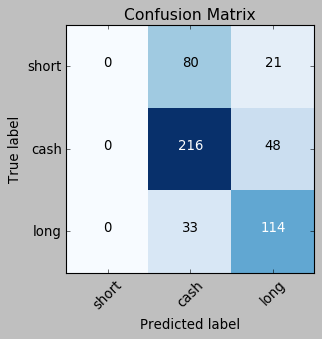

In [58]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test,prediction_test, classes= ['short', 'cash', 'long'],
normalize=False, title='Confusion Matrix')
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'])
print(rpt)

# CNN REgressor

1 out of  1 filters =  10 units =  160 lr =  3e-05 batch_size =  64 epoch =  100
0.0372 0.0282 339.66


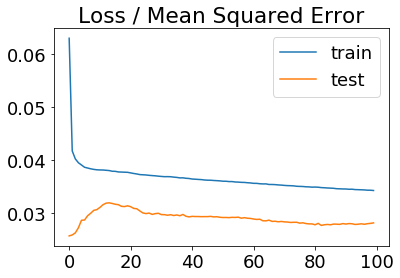

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_291 (Conv1D)          (None, 36, 10)            660       
_________________________________________________________________
conv1d_292 (Conv1D)          (None, 32, 10)            510       
_________________________________________________________________
max_pooling1d_146 (MaxPoolin (None, 10, 10)            0         
_________________________________________________________________
flatten_141 (Flatten)        (None, 100)               0         
_________________________________________________________________
dense_287 (Dense)            (None, 160)               16160     
_________________________________________________________________
dense_288 (Dense)            (None, 1)                 161       
Total params: 17,491
Trainable params: 17,491
Non-trainable params: 0
_________________________________________________________________


,filter,kernel,unit,lr,batch_size,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,10,5,160,0.00003,64,339.66,118.36,162.57,0.0372,0.0282,0.0027,0.00128,-8.68,-10.19


In [53]:
train_ratio = 0.8
window_size = 40
look_forward =20

unit_table = []
lr_table = []
look_forward_table = []
window_size_table = []
batch_size_table = []
filter_table, kernel_size_table = [], []
time_table = []
epoch_table = []
smape_train = []
smape_test = []
mae_train = [] 
mae_test = [] 
mse_train = [] 
mse_test = [] 
r2_train =[]
r2_test = []

Units = [ 160]
lrs = [ 0.00003]
batch_sizes = [64]
epoch = [100]
Filters = [10]
kernel_sizes = [5]

counter = 0
for units in Units:
    for lr in lrs:
        for batch_size in batch_sizes:
            for epochs in epoch:
                for kernel_size in kernel_sizes:
                    for filters in Filters:
                        total = len(Units)*len(lrs)*len(batch_sizes)*len(epoch)*len(kernel_sizes)*len(Filters)
                        counter += 1
                        start_time = time.time()
                        #fixing rnd
                        fix_rnd_Keras()

                        scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                        MAs_scaled = scaler.fit_transform(MAs)
                        x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                        MAs_array = MAs.values
                        x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)

                        #just for dense ANN, remove this for lstm
                        #x = x.reshape(len(x), -1)
                        train_length = int(len(x)*train_ratio)

                        for i in range(train_length, train_length+batch_size):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length = i
                                break
                        x_train = x[:train_length,:]
                        y_train = y[:train_length,:]

                        for i in range(len(x)-batch_size, len(x)):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length_test = i
                                break
                        x_test = x[train_length:train_length_test,:]
                        y_test = y[train_length:train_length_test,:]

                        model = Sequential()
                        model.add(Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu',
                                         input_shape = (window_size, x_train.shape[2])))
                        model.add(Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu'))
                        model.add(MaxPooling1D(pool_size = 3))
                        model.add(Flatten())
                        model.add(Dense(units = units, activation='relu'))
                        model.add(Dense(units = 1))
                        opt = Adam(lr = lr)
                        model.compile(loss = 'mae', optimizer = opt)
                        history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                                            epochs = epochs, verbose = 0, shuffle=False)

                        print(counter, 'out of ', total, 'filters = ', filters, 'units = ', units, 'lr = ', lr, 
                              'batch_size = ', batch_size, 'epoch = ', epochs)

                        unit_table.append(units)
                        lr_table.append(lr)
                        batch_size_table.append(batch_size)

                        prediction_train = model.predict(x_train)
                        prediction_test = model.predict(x_test)
                        accuracy_train_smape = round(smape(prediction_train, y_train), 2)
                        accuracy_test_smape = round(smape(prediction_test, y_test), 2)
                        accuracy_train_mse = round(mse(prediction_train, y_train), 5)
                        accuracy_test_mse = round(mse(prediction_test, y_test), 5)
                        accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
                        accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
                        accuracy_train_mae = round(mae(prediction_train, y_train), 4)
                        accuracy_test_mae = round(mae(prediction_test, y_test), 4)
                        smape_train.append(accuracy_train_smape)
                        smape_test.append(accuracy_test_smape)
                        mse_train.append(accuracy_train_mse)
                        mse_test.append(accuracy_test_mse)
                        r2_train.append(accuracy_train_r2)
                        r2_test.append(accuracy_test_r2)
                        mae_train.append(accuracy_train_mae)
                        mae_test.append(accuracy_test_mae)
                        filter_table.append(filters)
                        kernel_size_table.append(kernel_size)
                        end_time = time.time()
                        time_table.append(round(end_time - start_time,2))
                        print(accuracy_train_mae, accuracy_test_mae, (round(end_time - start_time,2)))
                        pyplot.title('Loss / Mean Squared Error')
                        pyplot.plot(history.history['loss'], label='train')
                        pyplot.plot(history.history['val_loss'], label='test')
                        pyplot.legend()
                        pyplot.show()

hyper_parameters = pd.DataFrame(list(zip(filter_table, kernel_size_table, unit_table,lr_table,batch_size_table,
    time_table, smape_train, smape_test, mae_train, mae_test, mse_train, mse_test, r2_train, r2_test)),
        columns =['filter', 'kernel', 'unit','lr','batch_size','time','smape_train', 'smape_test',
                  'mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_test'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
model.summary()
hyper_parameters

In [52]:
hyper_parameters

,filter,kernel,unit,lr,batch_size,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,10,5,160,0.00003,64,75.5,124.81,144.8,0.0338,0.0261,0.0024,0.00123,-11.14,-10.89


In [33]:
hyper_parameters

,filter,kernel,unit,lr,batch_size,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,40,5,40,0.000030,64,4.21,131.04,131.73,0.0320,0.0322,0.00208,0.00166,-7.32,-6.26
1,10,5,40,0.000030,64,3.44,141.47,133.23,0.0354,0.0263,0.00248,0.00125,-14.04,-13.79
2,10,5,20,0.000003,64,3.45,136.70,134.84,0.0684,0.0434,0.00687,0.00270,-6.31,-12.20
3,10,5,40,0.000003,64,3.72,139.00,139.30,0.0412,0.0543,0.00318,0.00381,-3.84,-20.77
4,40,5,40,0.000003,64,4.30,143.40,148.98,0.0384,0.0371,0.00262,0.00214,-2.97,-9.09
5,40,5,20,0.000030,64,3.68,129.92,152.97,0.0331,0.0282,0.00222,0.00130,-9.16,-8.64
6,40,5,20,0.000003,64,3.87,144.97,155.24,0.0370,0.0340,0.00255,0.00171,-5.52,-9.12
7,10,5,20,0.000030,64,3.06,143.72,160.98,0.0367,0.0272,0.00254,0.00129,-7.06,-11.10


In [35]:
hyper_parameters

,filter,kernel,unit,lr,batch_size,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,10,5,80,0.00001,64,4.60,144.04,124.77,0.0359,0.0307,0.00246,0.00158,-11.99,-41.01
1,10,5,80,0.00009,64,5.01,130.94,129.60,0.0335,0.0261,0.00224,0.00125,-26.80,-48.51
2,10,5,40,0.00001,64,4.71,140.42,129.65,0.0387,0.0405,0.00285,0.00242,-5.57,-16.83
3,10,5,80,0.00003,64,4.91,139.39,130.23,0.0345,0.0262,0.00233,0.00125,-24.57,-46.75
4,20,5,80,0.00001,64,4.91,136.69,132.17,0.0358,0.0315,0.00256,0.00163,-5.04,-9.67
5,10,5,40,0.00003,64,3.85,141.54,133.42,0.0354,0.0263,0.00248,0.00124,-14.05,-13.78
6,20,5,40,0.00001,64,5.07,139.97,135.44,0.0358,0.0316,0.00253,0.00164,-5.15,-7.07
7,20,5,40,0.00003,64,4.05,136.77,138.08,0.0342,0.0291,0.00237,0.00142,-7.44,-9.72
8,20,5,40,0.00009,64,5.69,128.82,141.07,0.0323,0.0287,0.00221,0.00138,-8.26,-10.57
9,20,5,80,0.00003,64,5.23,132.46,154.29,0.0335,0.0271,0.00232,0.00126,-6.89,-11.55


In [39]:
hyper_parameters

,filter,kernel,unit,lr,batch_size,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,15,5,160,0.00009,64,88.59,112.60,123.58,0.0256,0.0333,0.00153,0.00181,-1.87,-6.87
1,15,5,160,0.00009,32,58.24,105.12,124.38,0.0259,0.0301,0.00159,0.00149,-1.87,-6.66
2,15,5,160,0.00003,32,81.90,118.03,125.75,0.0288,0.0291,0.00185,0.00141,-5.16,-9.06
3,15,5,160,0.00003,64,84.85,119.19,126.64,0.0288,0.0288,0.00184,0.00137,-5.16,-8.95
4,15,5,160,0.00001,64,125.84,129.08,126.88,0.0319,0.0278,0.00212,0.00132,-13.44,-10.15
5,15,5,160,0.00001,32,113.06,129.19,126.91,0.0319,0.0279,0.00212,0.00132,-13.37,-10.05
6,10,5,80,0.00003,64,28.48,129.71,137.70,0.0329,0.0260,0.00225,0.00126,-8.20,-5.29
7,10,5,80,0.00009,32,31.66,123.30,137.70,0.0306,0.0249,0.00204,0.00117,-7.22,-7.18
8,10,10,160,0.00001,64,97.99,136.43,138.07,0.0342,0.0253,0.00235,0.00117,-12.27,-6.77
9,5,5,80,0.00009,64,27.99,117.95,138.66,0.0288,0.0284,0.00186,0.00139,-7.01,-9.29


In [42]:
hyper_parameters = hyper_parameters.sort_values(by=['mae_test'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

,filter,kernel,unit,lr,batch_size,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,5,10,80,0.00003,64,26.23,131.16,146.98,0.0323,0.0247,0.00211,0.00108,-18.50,-15.43
1,5,10,80,0.00003,32,24.87,131.32,146.99,0.0323,0.0247,0.00211,0.00108,-18.61,-15.59
2,5,10,80,0.00001,64,36.72,141.77,154.67,0.0339,0.0248,0.00222,0.00108,-21.00,-14.94
3,5,10,80,0.00001,32,35.36,141.63,153.25,0.0339,0.0248,0.00222,0.00108,-20.49,-14.34
4,10,5,80,0.00009,32,31.66,123.30,137.70,0.0306,0.0249,0.00204,0.00117,-7.22,-7.18
5,5,10,160,0.00001,32,62.37,136.61,153.80,0.0336,0.0252,0.00228,0.00112,-52.81,-20.82
6,10,10,160,0.00001,64,97.99,136.43,138.07,0.0342,0.0253,0.00235,0.00117,-12.27,-6.77
7,5,10,160,0.00001,64,69.80,136.99,154.03,0.0336,0.0253,0.00228,0.00112,-52.16,-20.78
8,10,5,80,0.00009,64,35.19,126.64,140.20,0.0306,0.0254,0.00201,0.00119,-6.94,-7.67
9,10,10,160,0.00001,32,80.17,137.51,139.13,0.0341,0.0254,0.00233,0.00116,-12.78,-7.16


[0, 900, -0.1, 0.1]

<Figure size 432x288 with 0 Axes>

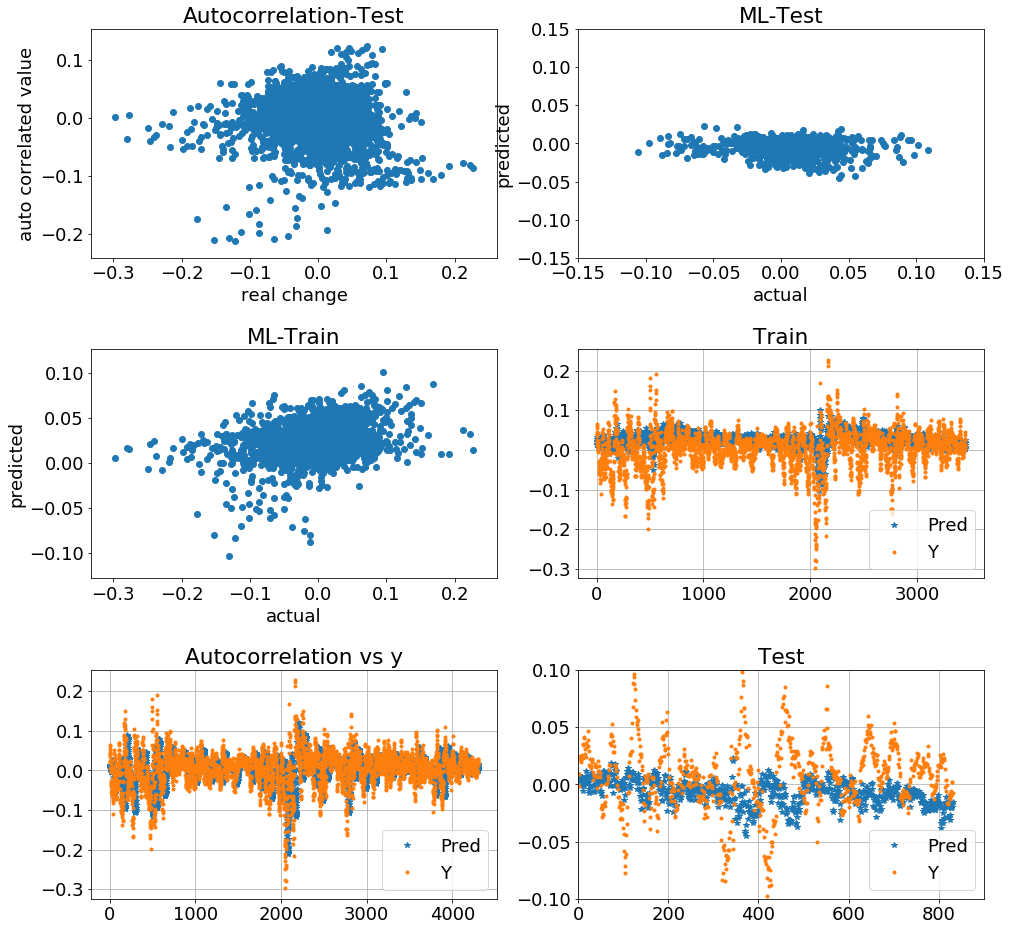

In [54]:
fig = plt.figure()
plt.rcParams.update({'font.size': 18})
plt.subplots_adjust(hspace = 0.4)
plt.figure(figsize=(16,16))
plt.subplot(3, 2, 1)
plt.scatter(y1,y2)
plt.ylabel('auto correlated value')
plt.xlabel('real change')
plt.title('Autocorrelation-Test')
plt.subplots_adjust(hspace = 0.4)

plt.subplot(3, 2, 2)
plt.scatter(y_test, prediction_test)
plt.ylabel('predicted')
plt.xlabel('actual')
plt.title('ML-Test')
plt.axis([-0.15, 0.15, -0.15, 0.15])

plt.subplot(3, 2, 3)
plt.scatter(y_train, prediction_train)
plt.ylabel('predicted')
plt.xlabel('actual')
plt.title('ML-Train')

plt.subplot(3, 2, 4)
plt.plot(prediction_train, marker = '*',linestyle="None", label = 'Pred')
plt.plot(y_train, marker = '.', label = 'Y', linestyle="None")
plt.grid()
plt.legend()
plt.title('Train')

plt.subplot(3, 2, 5)
plt.plot(y2, marker = '*',linestyle="None", label = 'Pred')
plt.plot(y1, marker = '.', label = 'Y', linestyle="None")
plt.grid()
plt.legend()
plt.title('Autocorrelation vs y')

plt.subplot(3, 2, 6)
plt.plot(prediction_test, marker = '*', label = 'Pred',linestyle="None")
plt.plot(y_test, marker = '.',linestyle="None" , label = 'Y')
plt.grid()
plt.legend()
plt.title('Test')
plt.axis([0, 900, -0.1, 0.1])

# CNN Classifier

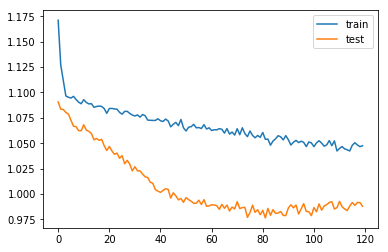

36.06 filters = 24 kernel = 8 1 out of  1 units =  40 lr =  9e-05 batch_size =  256 epoch =  120 long prec =  0.736 fscore =  0.6764705882352942
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 13, 24)            2520      
_________________________________________________________________
dropout_85 (Dropout)         (None, 13, 24)            0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 312)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 40)                12520     
_________________________________________________________________
dropout_86 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 40)                1640    

,kernel_size,filters,unit,epoch,lr,batch,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,8,24,40,120,0.00009,256,36.06,0.676471,0.736,0.645669,0.0,0.492257,0.492501,0.688073


In [20]:
train_ratio = 0.8
window_size = 20
look_forward =20

unit_table = []
lr_table = []
look_forward_table = []
window_size_table = []
batch_size_table = []
filter_table, kernel_size_table = [], []
time_table = []
epoch_table = []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr, long_fscores =  [], [], [], [], [], []



Units = [40]
lrs = [ 0.00009]
batch_sizes = [ 256]
epoch = [120]
Filters = [24]
kernel_sizes = [8]

counter = 0
for units in Units:
    for lr in lrs:
        for batch_size in batch_sizes:
            for epochs in epoch:
                for kernel_size in kernel_sizes:
                    for filters in Filters:
                        total = len(Units)*len(lrs)*len(batch_sizes)*len(epoch)*len(kernel_sizes)*len(Filters)
                        counter += 1
                        start_time = time.time()
                        #fixing rnd
                        fix_rnd_Keras()

                        scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                        MAs_scaled = scaler.fit_transform(MAs)
                        x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                        MAs_array = MAs.values
                        x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)
                        y = y_classifier(y, 0.02)
                        y = y_softmax(y)
                        #just for dense ANN, remove this for lstm
                        #x = x.reshape(len(x), -1)
                        train_length = int(len(x)*train_ratio)

                        for i in range(train_length, train_length+batch_size):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length = i
                                break
                        x_train = x[:train_length,:]
                        y_train = y[:train_length,:]

                        for i in range(len(x)-batch_size, len(x)):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length_test = i
                                break
                        x_test = x[train_length:train_length_test,:]
                        y_test = y[train_length:train_length_test,:]

                        model = Sequential()
                        model.add(Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu',
                                         input_shape = (window_size, x_train.shape[2])))
                        model.add(Dropout(0.5))
                        #model.add(MaxPooling1D(pool_size = 3))
                        model.add(Flatten())
                        model.add(Dense(units = units, activation='relu'))
                        model.add(Dropout(0.5))
                        model.add(Dense(units = units, activation='relu'))
                        model.add(Dropout(0.5))

                        model.add(Dense(3, activation='softmax'))
                        opt = Adam(lr = lr)
                        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
                        history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                                            epochs = epochs, verbose = 0, shuffle=False)

                        pyplot.plot(history.history['loss'], label='train')
                        pyplot.plot(history.history['val_loss'], label='test')
                        pyplot.legend()
                        pyplot.show()
                        unit_table.append(units)
                        lr_table.append(lr)
                        batch_size_table.append(batch_size)
                        prediction_train = model.predict(x_train, batch_size=batch_size)
                        prediction_test = model.predict(x_test, batch_size=batch_size)
                        y_train, y_test, prediction_train, prediction_test = desoftmaxer(y_train), desoftmaxer(y_test),desoftmaxer(prediction_train), desoftmaxer(prediction_test)
                        rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                                    output_dict=True )
                        long_precision =  rpt['long']['precision']
                        long_fscore = rpt['long']['f1-score']
                        cash_precision =  rpt['cash']['precision']
                        short_precision =  rpt['short']['precision']
                        long_rec =  rpt['long']['recall']
                        cash_rec =  rpt['cash']['recall']
                        short_rec =  rpt['short']['recall']
                        rptt = classification_report(y_train, prediction_train, target_names = ['short','cash','long'], 
                                                     output_dict=True )
                        long_precision_t =  rptt['long']['precision']
                        cash_precision_t =  rptt['cash']['precision']
                        short_precision_t =  rptt['short']['precision']
                        long_rec_t =  rptt['long']['recall']
                        cash_rec_t =  rptt['cash']['recall']
                        short_rec_t =  rptt['short']['recall']
                        long_prec.append(long_precision)
                        cash_prec.append(cash_precision)
                        short_prec.append(short_precision)
                        long_recal.append(long_rec)
                        cash_recal.append(cash_rec)
                        short_recal.append(short_rec)
                        long_prec_tr.append(long_precision_t)
                        cash_prec_tr.append(cash_precision_t)
                        short_prec_tr.append(short_precision_t)
                        long_recal_tr.append(long_rec_t)
                        cash_recal_tr.append(cash_rec_t)
                        short_recal_tr.append(short_rec_t)
                        long_fscores.append(long_fscore)
                        epoch_table.append(epochs)
                        filter_table.append(filters)
                        kernel_size_table.append(kernel_size)

                        end_time = time.time()
                        time_table.append(round(end_time - start_time,2))
                        print(round(end_time - start_time,2), 'filters =', filters, 'kernel =', kernel_size, counter, 'out of ', total, 'units = ', units, 'lr = ', 
lr, 'batch_size = ', batch_size, 'epoch = ', epochs,'long prec = ', long_precision, 'fscore = ', long_fscore)
            
hyper_parameters = pd.DataFrame(list(zip( kernel_size_table,filter_table, unit_table, epoch_table, lr_table, batch_size_table, time_table,
                                         long_fscores, long_prec, 
            cash_prec, short_prec, long_prec_tr, cash_prec_tr, short_prec_tr )),
            columns =['kernel_size', 'filters','unit', 'epoch', 'lr', 'batch', 'time', 'long_fscore_test', 'long_prec',
'cash_prec', 'short_prec', 'long_prec_train', 'cash_prec_train', 'short_prec_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
model.summary()
hyper_parameters

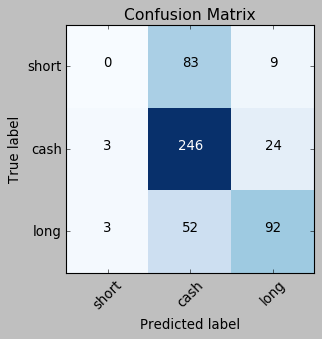

In [21]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test,prediction_test, classes= ['short', 'cash', 'long'],
normalize=False, title='Confusion Matrix')

In [22]:
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'])
print(rpt)

              precision    recall  f1-score   support

       short       0.00      0.00      0.00        92
        cash       0.65      0.90      0.75       273
        long       0.74      0.63      0.68       147

   micro avg       0.66      0.66      0.66       512
   macro avg       0.46      0.51      0.48       512
weighted avg       0.56      0.66      0.60       512



In [13]:
hyper_parameters # window 20

,kernel_size,filters,unit,epoch,lr,batch,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,8,24,40,130,0.00009,256,30.54,0.673759,0.703704,0.653951,0.0,0.503683,0.494076,0.679389


In [39]:
hyper_parameters

,kernel_size,filters,unit,epoch,lr,batch,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,5,3,40,130,0.00003,256,34.58,0.307692,0.717949,0.562368,0.0,0.427907,0.422581,0.551724


In [19]:
hyper_parameters

,kernel_size,filters,unit,epoch,lr,batch,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,8,24,40,120,0.00009,256,33.91,0.697318,0.798246,0.643766,0.0,0.503185,0.490252,0.681416
1,8,24,40,120,0.00009,256,33.63,0.690909,0.742188,0.647368,0.0,0.502904,0.489143,0.696429
2,8,24,40,120,0.00009,256,33.25,0.684211,0.764706,0.643411,0.0,0.501444,0.490534,0.690909
3,8,24,40,120,0.00009,256,33.99,0.671587,0.733871,0.645669,0.0,0.500864,0.488453,0.704348
4,8,24,35,120,0.00009,256,33.19,0.642857,0.676692,0.641161,0.0,0.499726,0.493529,0.661017
5,8,24,35,120,0.00009,256,35.85,0.633803,0.656934,0.637333,0.0,0.513593,0.492950,0.689076
6,8,24,35,120,0.00009,256,39.33,0.630435,0.674419,0.633508,0.0,0.496241,0.501230,0.625000
7,8,24,35,120,0.00009,256,33.11,0.624561,0.644928,0.638814,0.0,0.509368,0.488649,0.649123
8,8,24,45,120,0.00009,256,36.08,0.483019,0.542373,0.644068,0.0,0.519277,0.496032,0.600000
9,8,24,45,120,0.00009,256,38.91,0.462745,0.546296,0.652047,0.0,0.516243,0.498554,0.592593


In [43]:
hyper_parameters

,kernel_size,filters,unit,epoch,lr,batch,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,5,24,40,130,0.00003,256,61.33,0.604082,0.72549,0.605459,0.142857,0.485695,0.448570,0.704545
1,5,12,40,130,0.00003,256,49.09,0.166667,1.00000,0.551102,0.000000,0.476091,0.444919,0.714286


# XGBoost Regressor

In [45]:
train_ratio = 0.8
window_size = 1
look_forward =20
batch_size = 16
seed_value= 0
lrs_t, cols_t, ns_t, depths_t, subs_t, gamma_t = [], [], [], [], [], []
time_table, smape_test, smape_train, mae_train, mae_test = [], [], [], [], []
mse_train, mse_test, r2_train, r2_test = [], [], [], []
lrs = [0.15] 
cols = [0.7]
ns = [70]
depths = [3]
subs = [0.7]
gammas = [0]
counter = 0
for lr in lrs:
    for col in cols:
        for n in ns:
            for depth in depths:
                for gamma in gammas:
                    for sub in subs:
                        counter +=1
                        start_time = time.time()
                        total = len(lrs)*len(cols)*len(ns)*len(depths)*len(gammas)*len(subs)
                        fix_rnd_Keras()

                        scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                        MAs_scaled = scaler.fit_transform(MAs)
                        x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                        MAs_array = MAs.values
                        x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)

                        #just for dense ANN, remove this for lstm
                        y = y.ravel()
                        x = x.reshape(len(x), -1)
                        train_length = int(len(x)*train_ratio)

                        for i in range(train_length, train_length+batch_size):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length = i
                                break
                        x_train = x[:train_length,:]
                        y_train = y[:train_length,]

                        for i in range(len(x)-batch_size, len(x)):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length_test = i
                                break
                        x_test = x[train_length:train_length_test,:]
                        y_test = y[train_length:train_length_test,]

                        model = XGBRegressor(learning_rate=lr, colsample_bytree = col, subsample = sub, 
n_estimators=n, max_depth=depth, gamma=gamma, objective = 'reg:squarederror')
                        model.fit(x_train, y_train)  
                        prediction_train = model.predict(x_train)
                        prediction_test = model.predict(x_test)
                        accuracy_train_smape = round(smape(prediction_train, y_train), 2)
                        accuracy_test_smape = round(smape(prediction_test, y_test), 2)
                        accuracy_train_mse = round(mse(prediction_train, y_train), 5)
                        accuracy_test_mse = round(mse(prediction_test, y_test), 5)
                        accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
                        accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
                        accuracy_train_mae = round(mae(prediction_train, y_train), 4)
                        accuracy_test_mae = round(mae(prediction_test, y_test), 4)
                        smape_train.append(accuracy_train_smape)
                        smape_test.append(accuracy_test_smape)
                        mse_train.append(accuracy_train_mse)
                        mse_test.append(accuracy_test_mse)
                        r2_train.append(accuracy_train_r2)
                        r2_test.append(accuracy_test_r2)
                        mae_train.append(accuracy_train_mae)
                        mae_test.append(accuracy_test_mae)
                        end_time = time.time()
                        time_table.append(round(end_time - start_time,2))
                        lrs_t.append(lr)
                        cols_t.append(col)
                        ns_t.append(n)
                        depths_t.append(depth)
                        subs_t.append(sub)
                        gamma_t.append(gamma)
                        print(round(end_time - start_time,2),counter, 'out of ', total,'lr = ', lr, 'col = ', col,
                        'n= ', n, 'depth =', depth, sub, accuracy_test_r2, accuracy_test_mae )
hyper_parameters = pd.DataFrame(list(zip(lrs_t, cols_t, ns_t, depths_t, subs_t, gamma_t, time_table, smape_train, smape_test,
mae_train, mae_test, mse_train, mse_test, r2_train, r2_test)), columns =['lrs','columns', 'n_estimator', 'depth',
'subsample', 'gamma', 'time', 'smape_train', 'smape_test','mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_test'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

0.25 1 out of  1 lr =  0.15 col =  0.7 n=  70 depth = 3 0.7 -8.72 0.0209


,lrs,columns,n_estimator,depth,subsample,gamma,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,0.15,0.7,70,3,0.7,0,0.25,121.71,129.23,0.0263,0.0209,0.00119,0.00086,-0.74,-8.72


In [41]:
hyper_parameters = hyper_parameters.sort_values(by=['mae_test'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

,lrs,columns,n_estimator,depth,subsample,gamma,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,0.15,0.7,70,3,0.7,0,0.24,121.71,129.23,0.0263,0.0209,0.00119,0.00086,-7.400000e-01,-8.720000e+00
1,0.05,0.6,100,5,0.6,0,0.41,111.46,117.48,0.0246,0.0210,0.00106,0.00088,-6.000000e-01,-1.270000e+01
2,0.10,0.7,100,4,0.7,0,0.40,110.45,129.38,0.0230,0.0210,0.00090,0.00089,-5.000000e-02,-5.260000e+00
3,0.15,0.7,50,3,0.7,0,0.18,125.45,121.38,0.0273,0.0210,0.00129,0.00088,-1.120000e+00,-1.108000e+01
4,0.10,0.7,70,4,0.7,0,0.28,118.01,132.14,0.0251,0.0210,0.00108,0.00087,-5.600000e-01,-8.600000e+00
5,0.10,0.7,100,3,0.7,0,0.33,122.01,125.90,0.0264,0.0210,0.00121,0.00087,-8.400000e-01,-1.169000e+01
6,0.10,0.6,70,5,0.7,0,0.31,109.29,128.35,0.0226,0.0211,0.00088,0.00089,-6.000000e-02,-9.060000e+00
7,0.15,0.7,100,3,0.7,0,0.33,116.21,131.60,0.0246,0.0211,0.00103,0.00086,-2.600000e-01,-7.750000e+00
8,0.15,0.7,50,3,0.6,0,0.17,125.65,127.14,0.0275,0.0211,0.00132,0.00088,-1.300000e+00,-9.070000e+00
9,0.10,0.6,100,3,0.7,0,0.29,122.33,123.31,0.0265,0.0212,0.00123,0.00089,-9.100000e-01,-1.285000e+01


In [43]:
hyper_parameters

,lrs,columns,n_estimator,depth,subsample,gamma,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,0.05,0.9,70,3,0.6,0.2,0.28,123.05,115.07,0.0347,0.0229,0.00243,0.00097,-161.63,-152474.81
1,0.05,0.6,70,7,0.7,0.5,0.34,123.53,114.90,0.0352,0.0230,0.00252,0.00097,0.00,0.00
2,0.05,0.9,70,3,0.6,0.5,0.25,123.56,114.91,0.0352,0.0230,0.00252,0.00097,0.00,0.00
3,0.05,0.9,70,5,0.6,0.5,0.35,123.56,114.91,0.0352,0.0230,0.00252,0.00097,0.00,0.00
4,0.05,0.9,70,7,0.6,0.5,0.45,123.56,114.91,0.0352,0.0230,0.00252,0.00097,0.00,0.00
5,0.05,0.6,70,5,0.7,0.2,0.26,123.06,115.47,0.0346,0.0230,0.00239,0.00098,-112.65,-2014.36
6,0.05,0.9,70,5,0.7,0.5,0.40,123.53,114.90,0.0352,0.0230,0.00252,0.00097,0.00,0.00
7,0.05,0.9,70,3,0.7,0.5,0.26,123.53,114.90,0.0352,0.0230,0.00252,0.00097,0.00,0.00
8,0.05,0.9,70,7,0.7,0.5,0.46,123.53,114.90,0.0352,0.0230,0.00252,0.00097,0.00,0.00
9,0.05,0.6,70,3,0.7,0.5,0.21,123.53,114.90,0.0352,0.0230,0.00252,0.00097,0.00,0.00


In [35]:
hyper_parameters.head(20)

,lrs,columns,n_estimator,depth,subsample,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,0.1,0.7,100,4,0.7,0.40,110.45,129.38,0.0230,0.0210,0.00090,0.00089,-0.05,-5.26
1,0.1,0.7,100,3,0.7,0.32,122.01,125.90,0.0264,0.0210,0.00121,0.00087,-0.84,-11.69
2,0.1,0.7,200,3,0.7,0.62,110.62,128.15,0.0231,0.0211,0.00092,0.00089,-0.04,-4.92
3,0.1,0.6,100,3,0.7,0.31,122.33,123.31,0.0265,0.0212,0.00123,0.00089,-0.91,-12.85
4,0.1,0.7,200,3,0.6,0.62,112.86,127.75,0.0235,0.0213,0.00095,0.00093,-0.08,-4.58
5,0.1,0.6,100,4,0.6,0.35,112.33,127.85,0.0236,0.0213,0.00095,0.00092,-0.15,-6.62
6,0.1,0.7,50,4,0.7,0.22,118.51,123.41,0.0263,0.0213,0.00123,0.00088,-1.12,-18.11
7,0.1,0.6,50,5,0.6,0.22,113.05,117.74,0.0244,0.0213,0.00105,0.00092,-0.55,-10.91
8,0.1,0.6,100,4,0.7,0.35,111.62,126.35,0.0234,0.0213,0.00094,0.00092,-0.14,-6.35
9,0.1,0.7,100,4,0.6,0.39,110.78,125.42,0.0233,0.0213,0.00093,0.00092,-0.10,-7.24


In [15]:
accuracy_train_smape

533156.01

[0, 900, -0.1, 0.1]

<Figure size 432x288 with 0 Axes>

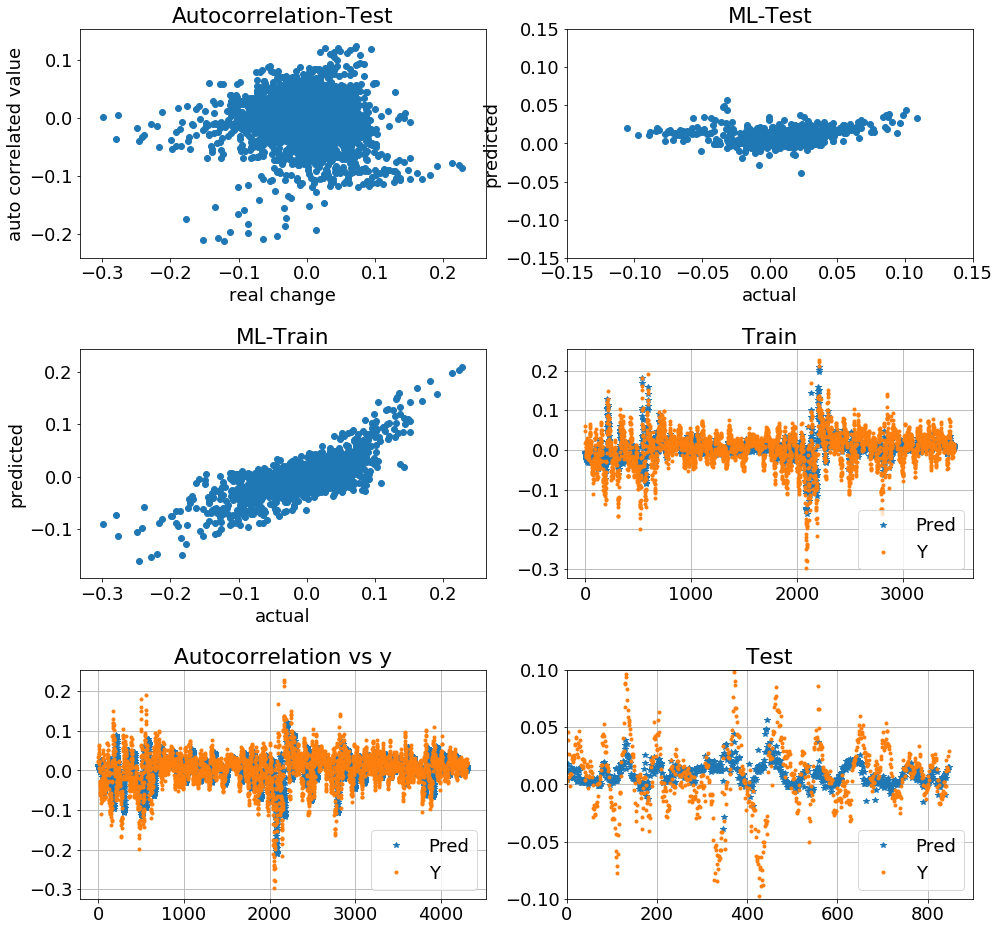

In [46]:
fig = plt.figure()
plt.rcParams.update({'font.size': 18})
plt.subplots_adjust(hspace = 0.4)
plt.figure(figsize=(16,16))
plt.subplot(3, 2, 1)
plt.scatter(y1,y2)
plt.ylabel('auto correlated value')
plt.xlabel('real change')
plt.title('Autocorrelation-Test')
plt.subplots_adjust(hspace = 0.4)

plt.subplot(3, 2, 2)
plt.scatter(y_test, prediction_test)
plt.ylabel('predicted')
plt.xlabel('actual')
plt.title('ML-Test')
plt.axis([-0.15, 0.15, -0.15, 0.15])

plt.subplot(3, 2, 3)
plt.scatter(y_train, prediction_train)
plt.ylabel('predicted')
plt.xlabel('actual')
plt.title('ML-Train')

plt.subplot(3, 2, 4)
plt.plot(prediction_train, marker = '*',linestyle="None", label = 'Pred')
plt.plot(y_train, marker = '.', label = 'Y', linestyle="None")
plt.grid()
plt.legend()
plt.title('Train')

plt.subplot(3, 2, 5)
plt.plot(y2, marker = '*',linestyle="None", label = 'Pred')
plt.plot(y1, marker = '.', label = 'Y', linestyle="None")
plt.grid()
plt.legend()
plt.title('Autocorrelation vs y')

plt.subplot(3, 2, 6)
plt.plot(prediction_test, marker = '*', label = 'Pred',linestyle="None")
plt.plot(y_test, marker = '.',linestyle="None" , label = 'Y')
plt.grid()
plt.legend()
plt.title('Test')
plt.axis([0, 900, -0.1, 0.1])

# XGboost Classifier

In [35]:
train_ratio = 0.8
window_size = 1
look_forward =20
batch_size = 16
seed_value= 0
lrs_t, cols_t, ns_t, depths_t, subs_t, gamma_t, time_table = [], [], [], [], [], [], []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr, l_f_s_t =  [],[],[],[],[],[],[], []
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr, long_fscores =  [], [], [], [], [], []
lrs = [2] 
cols = [ 1]
ns = [ 150]
depths = [2]
subs = [0.6]
gammas = [ 13]
counter = 0
for lr in lrs:
    for col in cols:
        for n in ns:
            for depth in depths:
                for gamma in gammas:
                    for sub in subs:
                        counter +=1
                        start_time = time.time()
                        total = len(lrs)*len(cols)*len(ns)*len(depths)*len(gammas)*len(subs)
                        fix_rnd_Keras()

                        scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                        MAs_scaled = scaler.fit_transform(MAs)
                        x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                        MAs_array = MAs.values
                        x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)
                        y = y_classifier(y, 0.02)
                        #just for dense ANN, remove this for lstm
                        y = y.ravel()
                        x = x.reshape(len(x), -1)
                        train_length = int(len(x)*train_ratio)

                        for i in range(train_length, train_length+batch_size):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length = i
                                break
                        x_train = x[:train_length,:]
                        y_train = y[:train_length,]

                        for i in range(len(x)-batch_size, len(x)):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length_test = i
                                break
                        x_test = x[train_length:train_length_test,:]
                        y_test = y[train_length:train_length_test,]

                        model = XGBClassifier(learning_rate=lr, colsample_bytree = col, subsample = sub, 
n_estimators=n, max_depth=depth, gamma=gamma, objective = 'reg:squarederror')
                        model.fit(x_train, y_train)  
                        prediction_train = model.predict(x_train)
                        prediction_test = model.predict(x_test)
                        rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                                    output_dict=True )
                        long_precision =  rpt['long']['precision']
                        long_fscore = rpt['long']['f1-score']
                        cash_precision =  rpt['cash']['precision']
                        short_precision =  rpt['short']['precision']
                        long_rec =  rpt['long']['recall']
                        cash_rec =  rpt['cash']['recall']
                        short_rec =  rpt['short']['recall']
                        rptt = classification_report(y_train, prediction_train, target_names = ['short','cash','long'], 
                                                     output_dict=True )
                        long_precision_t =  rptt['long']['precision']
                        cash_precision_t =  rptt['cash']['precision']
                        short_precision_t =  rptt['short']['precision']
                        long_rec_t =  rptt['long']['recall']
                        cash_rec_t =  rptt['cash']['recall']
                        short_rec_t =  rptt['short']['recall']
                        long_fscore_t = rptt['long']['f1-score']
                        long_prec.append(long_precision)
                        cash_prec.append(cash_precision)
                        short_prec.append(short_precision)
                        long_recal.append(long_rec)
                        cash_recal.append(cash_rec)
                        short_recal.append(short_rec)
                        long_prec_tr.append(long_precision_t)
                        cash_prec_tr.append(cash_precision_t)
                        short_prec_tr.append(short_precision_t)
                        long_recal_tr.append(long_rec_t)
                        cash_recal_tr.append(cash_rec_t)
                        short_recal_tr.append(short_rec_t)
                        long_fscores.append(long_fscore)
                        end_time = time.time()
                        time_table.append(round(end_time - start_time,2))
                        lrs_t.append(lr)
                        cols_t.append(col)
                        ns_t.append(n)
                        depths_t.append(depth)
                        subs_t.append(sub)
                        gamma_t.append(gamma)
                        l_f_s_t.append(long_fscore_t)
                        print(round(end_time - start_time,2),counter, 'out of ', total,'lr = ', lr, 'col = ', col,
                        'n= ', n, 'depth =', depth, long_fscore, long_fscore_t )
                        
hyper_parameters = pd.DataFrame(list(zip(lrs_t, cols_t, ns_t, depths_t, subs_t, gamma_t, time_table, long_fscores, 
long_prec, cash_prec, short_prec, long_prec_tr, cash_prec_tr, short_prec_tr, l_f_s_t)), columns =['lrs','columns', 
'n_estimator', 'depth','subsample', 'gamma', 'time', 'long_fscore_test', 'long_prec',
'cash_prec', 'short_prec', 'long_prec_train', 'cash_prec_train', 'short_prec_train', 'long_fscore_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

1.34 1 out of  1 lr =  2 col =  1 n=  150 depth = 2 0.5603864734299517 0.5988372093023255


,lrs,columns,n_estimator,depth,subsample,gamma,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train,long_fscore_train
0,2,1,150,2,0.6,13,1.34,0.560386,0.481994,0.69161,0.173913,0.570637,0.545085,0.570726,0.598837


,lrs,columns,n_estimator,depth,subsample,gamma,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train,long_fscore_train
0,0.50,0.7,30,2,0.5,10,0.26,0.468384,0.598802,0.632353,0.000000,0.508323,0.517588,0.612591,0.571906
1,0.50,0.7,70,2,0.5,10,0.54,0.468384,0.598802,0.632353,0.000000,0.506729,0.517730,0.628726,0.574080
2,0.15,0.7,70,2,0.5,10,0.51,0.394444,0.710000,0.610442,0.000000,0.508413,0.521088,0.559322,0.569314
3,0.15,0.7,30,2,0.5,10,0.25,0.351906,0.740741,0.602347,0.000000,0.505099,0.514825,0.519288,0.566050
4,0.15,0.7,30,3,0.5,10,0.30,0.188552,0.756757,0.577065,0.000000,0.524170,0.531069,0.614987,0.595041
5,0.15,0.7,70,3,0.5,10,0.64,0.106762,0.714286,0.569007,0.000000,0.532855,0.535000,0.620773,0.598256
6,0.50,0.5,70,3,0.5,10,0.58,0.097902,0.538462,0.573006,0.000000,0.541557,0.532586,0.596330,0.581445
7,0.50,0.5,70,3,0.7,10,0.59,0.015267,1.000000,0.559102,0.000000,0.554569,0.567463,0.642276,0.606103
8,0.50,0.7,30,3,0.5,10,0.30,0.015209,0.666667,0.568319,0.055556,0.533055,0.546521,0.643396,0.599263
9,0.50,0.7,30,3,0.5,1,0.33,0.015209,0.666667,0.560427,1.000000,0.696866,0.704025,0.755644,0.737032


,lrs,columns,n_estimator,depth,subsample,gamma,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train,long_fscore_train
0,1.5,0.9,70,2,0.5,10,0.54,0.548760,0.481159,0.672646,0.157895,0.541956,0.536868,0.541667,0.593847
1,0.5,0.7,30,3,0.5,20,0.31,0.510978,0.531120,0.660066,0.000000,0.516070,0.443963,0.606250,0.468919
2,0.5,0.7,30,2,0.5,20,0.27,0.510978,0.531120,0.660066,0.000000,0.516070,0.443963,0.606250,0.468919
3,0.5,0.7,70,3,0.5,20,0.65,0.509960,0.528926,0.660066,0.000000,0.521739,0.465153,0.625000,0.508235
4,1.5,0.7,30,3,0.7,20,0.31,0.500000,0.453125,0.660985,0.000000,0.485731,0.513944,0.596899,0.551405
5,1.5,0.9,30,3,0.7,20,0.32,0.500000,0.453125,0.660985,0.000000,0.485731,0.513944,0.596899,0.551405
6,0.5,0.9,30,3,0.5,20,0.32,0.496970,0.523404,0.660066,0.000000,0.517273,0.443963,0.608414,0.472591
7,0.5,0.9,30,2,0.5,20,0.32,0.496970,0.523404,0.660066,0.000000,0.517273,0.443963,0.608414,0.472591
8,0.5,0.7,30,2,0.5,10,0.27,0.468384,0.598802,0.632353,0.000000,0.508323,0.517588,0.612591,0.571906
9,0.5,0.7,70,2,0.5,10,0.54,0.468384,0.598802,0.632353,0.000000,0.506729,0.517730,0.628726,0.574080


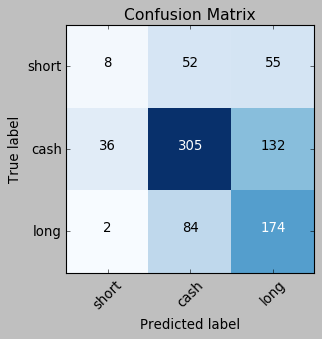

In [36]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test,prediction_test, classes= ['short', 'cash', 'long'],
normalize=False, title='Confusion Matrix')

In [37]:
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'])
print(rpt)

              precision    recall  f1-score   support

       short       0.17      0.07      0.10       115
        cash       0.69      0.64      0.67       473
        long       0.48      0.67      0.56       260

   micro avg       0.57      0.57      0.57       848
   macro avg       0.45      0.46      0.44       848
weighted avg       0.56      0.57      0.56       848

